# 🔥 Heat Storage Analysis Toolkit

Welcome to the **Heat Storage Analysis Toolkit** — a repository dedicated to the analysis and evaluation of energy, power, and thermal losses in heat storage systems. This toolkit provides a set of methods and utilities to process and analyze experimental or simulated data from thermal storage units, with a focus on identifying and quantifying charging and discharging behavior, estimating storage efficiency, and tracking loss dynamics over time.

Whether you're working with cavern thermal storage, water tanks, or phase-change materials, this repository offers flexible tools to:

- 📉 Compute **energy and power profiles** from temperature and flow measurements  
- 🔍 Identify **charging, discharging, and steady-state periods**  
- 🔥 Estimate **heat losses** and **efficiency degradation** over time  
- 📈 Apply gradient-based and cumulative energy methods for in-depth system diagnostics  
- ⚙️ Compare different analytical methods for loss detection and data smoothing

The repository is designed for researchers, engineers, and students working with thermal energy systems and seeking a transparent, customizable approach to analyzing their performance.


In [220]:
# READ THE DATA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from model_functions import *
from scipy.stats import mode
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import AutoLocator


# Suppress the RankWarning
warnings.filterwarnings('ignore', message='Polyfit may be poorly conditioned')

# Paths
vol_path = 'C:/Users/extaxha/Documents/project_data/volym_pejltabell.xlsx'
berg_path = 'C:/Users/extaxha/Documents/project_data/Temp berggrund.xlsx'
temp_path = 'C:/Users/extaxha/Documents/project_data/Temp Berget ALLT.xlsx'
power_path = 'C:/Users/extaxha/Documents/project_data/Laddeffekter ALLT.xlsx'
heat_flow_path = 'C:/Users/extaxha/Documents/project_data/Flöden och temperaturer VVX.xlsx'
path_levels = 'C:/Users/extaxha/Documents/project_data/Nivåer.xlsx'


berg_path = 'C:/Users/extaxha/Documents/project_data_final/Temp berggrund final.xlsx'
temp_path = 'C:/Users/extaxha/Documents/project_data_final/Temp Berget final.xlsx'
power_path = 'C:/Users/extaxha/Documents/project_data_final/Laddeffekter final.xlsx'
heat_flow_path = 'C:/Users/extaxha/Documents/project_data_final/Flöden och temperaturer VVX final.xlsx'
path_levels = 'C:/Users/extaxha/Documents/project_data_final/Nivåer final.xlsx'



# Read the Excel files
df_temp = pd.read_excel(temp_path, sheet_name=['Data skepp 1','Data skepp 2','Data skepp 3'])
df_vol =  pd.read_excel(vol_path)
df_power = pd.read_excel(power_path)
df_berg_temp_org = pd.read_excel(berg_path)
df_flow = pd.read_excel(heat_flow_path)
df_levels = pd.read_excel(path_levels, sheet_name='Sheet1')

######################## Adjust the power data ########################

# Define columns for the DataFrame
columns = ['Datum','Total Energi [MWh]', 'Skepp 1 - Effekt [MW]', 'Skepp 1 Energi [MWh]','Skepp 2 - Effekt [MW]', 'Skepp 2 Energi [MWh]','Skepp 3 - Effekt [MW]', 'Skepp 3 Energi [MWh]']

# Extrackt the relevant power data
df_measured_power = df_power.iloc[13:, 8:-1]
df_measured_power.columns = columns
df_measured_power_overall = df_power.iloc[9:13, 8:-1]
df_measured_power_overall.columns = columns

df_power = df_measured_power

# Remove NaN values from the specified columns
df_power = df_power.dropna(subset=columns)
df_power = df_power.iloc[:-1]


######################### Adjust the volume data ########################

# Remove nan values
pd.set_option('future.no_silent_downcasting', True)
df_vol.iloc[86:,:] = df_vol.iloc[86:,:].fillna(0.0)

# Load volume and area based on level: m, m^3, m^3, m^2. Step of 0.05 m
level_x = df_vol.iloc[86:, 1].values
skepp1_tot_vol_y = df_vol.iloc[86:, 2].values
skepp1_sep_vol_y = df_vol.iloc[86:, 3].values
skepp1_area_y = df_vol.iloc[86:, 4].values

skepp2_tot_vol_y = df_vol.iloc[86:, 7].values
skepp2_sep_vol_y = df_vol.iloc[86:, 8].values
skepp2_area_y = df_vol.iloc[86:, 9].values

skepp3_tot_vol_y = df_vol.iloc[86:, 12].values
skepp3_sep_vol_y = df_vol.iloc[86:, 13].values
skepp3_area_y = df_vol.iloc[86:, 14].values

# Adjust missing first value
skepp1_area_y[1] = skepp1_area_y[2]
skepp2_area_y[1] = skepp2_area_y[2]
skepp3_area_y[1] = skepp3_area_y[2]
skepp1_sep_vol_y[0] = 0
skepp2_sep_vol_y[0] = 0
skepp3_sep_vol_y[0] = 0

# remove the first 460 points to get rid of the first 23 m of data
top_volume1 = skepp1_sep_vol_y[460:]
top_volume2 = skepp2_sep_vol_y[460:]
top_volume3 = skepp3_sep_vol_y[460:]

# Sum up 20 steps to one to have a step of 1 meter
skepp1_sep_vol_y = np.add.reduceat(skepp1_sep_vol_y, np.arange(0, len(skepp1_sep_vol_y), 20))
skepp2_sep_vol_y = np.add.reduceat(skepp2_sep_vol_y, np.arange(0, len(skepp2_sep_vol_y), 20))
skepp3_sep_vol_y = np.add.reduceat(skepp3_sep_vol_y, np.arange(0, len(skepp3_sep_vol_y), 20))

# Remove the resulting last index and add it to the updated last index
skepp1_sep_vol_y[-2] += skepp1_sep_vol_y[-1]
skepp1_sep_vol_y = skepp1_sep_vol_y[:-1]

skepp2_sep_vol_y[-2] += skepp2_sep_vol_y[-1]
skepp2_sep_vol_y = skepp2_sep_vol_y[:-1]

skepp3_sep_vol_y[-2] += skepp3_sep_vol_y[-1]
skepp3_sep_vol_y = skepp3_sep_vol_y[:-1]

######################### Adjust the Bedrock temo data ########################

# Extract the relevant data from the DataFrame
berg_overall = df_berg_temp_org.iloc[9:13, 9:14].values
df_berg_temp = df_berg_temp_org.iloc[13:, 8:14]

# Define columns for the DataFrame
df_berg_temp.columns = ['time', '0.2m', '2.6m', '5.1m', '7.5m', '9.9m']
df_berg_temp['time'] = pd.to_datetime(df_berg_temp['time'])

# Remove the last row of the DataFrame
df_berg_temp = df_berg_temp.iloc[:-1]

######################### Adjust the Flow data ########################

# Define columns
flow_columns = ['date','T - lagervatten - varm - 1', 'T - lagervatten - varm - 2', 'T - lagervatten - varm - 3', 'T - lagervatten - kall - 1', 'T - lagervatten - kall - 2', 'T - lagervatten - kall - 3', 'Q - lagervatten - 1', 'Q - lagervatten - 2', 'Q - lagervatten - 3', 'T - fjärrvatten - varm - 1', 'T - fjärrvatten - varm - 2', 'T - fjärrvatten - varm - 3', 'T - fjärrvatten - kall - 1', 'T - fjärrvatten - kall - 2', 'T - fjärrvatten - kall - 3', 'Q - fjärrvatten - 1', 'Q - fjärrvatten - 2', 'Q - fjärrvatten - 3']

# Extract the relevant data from the DataFrame
df_flow_val = df_flow.values[14:,8:]
df_flow = pd.DataFrame(df_flow_val, columns=flow_columns)

# Remove the last row of the DataFrame
df_flow = df_flow.iloc[:-1]

# Replace missing values
df_flow['T - fjärrvatten - kall - 1'].iloc[452:512] = df_flow['T - fjärrvatten - kall - 1'].iloc[451]
df_flow['T - fjärrvatten - kall - 2'].iloc[452:512] = df_flow['T - fjärrvatten - kall - 2'].iloc[451]
df_flow['T - fjärrvatten - kall - 3'].iloc[452:512] = df_flow['T - fjärrvatten - kall - 3'].iloc[451]
df_flow['T - fjärrvatten - varm - 1'].iloc[452:512] = df_flow['T - fjärrvatten - varm - 1'].iloc[451]
df_flow['T - fjärrvatten - varm - 2'].iloc[452:512] = df_flow['T - fjärrvatten - varm - 2'].iloc[451]
df_flow['T - fjärrvatten - varm - 3'].iloc[452:512] = df_flow['T - fjärrvatten - varm - 3'].iloc[451]
df_flow['T - lagervatten - kall - 1'].iloc[452:512] = df_flow['T - lagervatten - kall - 1'].iloc[451]
df_flow['T - lagervatten - kall - 2'].iloc[452:512] = df_flow['T - lagervatten - kall - 2'].iloc[451]
df_flow['T - lagervatten - kall - 3'].iloc[452:512] = df_flow['T - lagervatten - kall - 3'].iloc[451]
df_flow['T - lagervatten - varm - 1'].iloc[452:512] = df_flow['T - lagervatten - varm - 1'].iloc[451]
df_flow['T - lagervatten - varm - 2'].iloc[452:512] = df_flow['T - lagervatten - varm - 2'].iloc[451]
df_flow['T - lagervatten - varm - 3'].iloc[452:512] = df_flow['T - lagervatten - varm - 3'].iloc[451]

df_flow['T - lagervatten - kall - 3'].iloc[1736:1880] = df_flow['T - fjärrvatten - kall - 3'].iloc[1736:1880]

# Replace odd datapoints
df_flow['T - lagervatten - varm - 1'] = replace_odd_datapoints_mean(df_flow['T - lagervatten - varm - 1'].values.reshape(-1, 1), threshold=20,step=3)[0].flatten()
df_flow['T - lagervatten - kall - 1'] = replace_odd_datapoints_mean(df_flow['T - lagervatten - kall - 1'].values.reshape(-1, 1), threshold=20,step=3)[0].flatten()
df_flow['T - lagervatten - varm - 2'] = replace_odd_datapoints_mean(df_flow['T - lagervatten - varm - 2'].values.reshape(-1, 1), threshold=20,step=3)[0].flatten()
df_flow['T - lagervatten - kall - 2'] = replace_odd_datapoints_mean(df_flow['T - lagervatten - kall - 2'].values.reshape(-1, 1), threshold=20,step=3)[0].flatten()
df_flow['T - lagervatten - varm - 3'] = replace_odd_datapoints_mean(df_flow['T - lagervatten - varm - 3'].values.reshape(-1, 1), threshold=20,step=3)[0].flatten()
df_flow['T - lagervatten - kall - 3'] = replace_odd_datapoints_mean(df_flow['T - lagervatten - kall - 3'].values.reshape(-1, 1), threshold=20,step=3)[0].flatten()

# Add a datetime signature one hour before the first entry in the 'date' column
first_datetime = pd.to_datetime(df_flow['date'].iloc[0]) - pd.Timedelta(hours=1)
new_row = {'date': first_datetime}

# Add zero values for all other columns in df_flow
for col in df_flow.columns[1:]:
    new_row[col] = 0

# Insert the new row at the beginning of the DataFrame
df_flow = pd.concat([pd.DataFrame([new_row]), df_flow], ignore_index=True)

######################### Adjust the Level data ########################

# Extract the relevant data from the DataFrame
df_levels = df_levels.iloc[13:, 8:12]
df_levels.columns = ['Datum', 'Skepp 1 [m]', 'Skepp 2 [m]', 'Skepp 3 [m]']

# Replace missing values
df_levels['Skepp 1 [m]'].iloc[453:512] = df_levels['Skepp 1 [m]'].iloc[452]
df_levels['Skepp 2 [m]'].iloc[453:512] = df_levels['Skepp 2 [m]'].iloc[452]
df_levels['Skepp 3 [m]'].iloc[453:512] = df_levels['Skepp 3 [m]'].iloc[452]

# Reshape the 1D array into a 2D array with one column
df_levels['Skepp 1 [m]'] = replace_odd_datapoints(df_levels['Skepp 1 [m]'].values.reshape(-1, 1), threshold=1.3, step=2)[0].flatten()
df_levels['Skepp 2 [m]'] = replace_odd_datapoints(df_levels['Skepp 2 [m]'].values.reshape(-1, 1), threshold=1.1, step=2)[0].flatten()
df_levels['Skepp 3 [m]'] = replace_odd_datapoints(df_levels['Skepp 3 [m]'].values.reshape(-1, 1), threshold=1.3, step=2)[0].flatten()


######################## Adjust the temp data ########################

# Access the specific DataFrame
df_skepp1 = df_temp['Data skepp 1']
df_skepp2 = df_temp['Data skepp 2']
df_skepp3 = df_temp['Data skepp 3']

# The min, max, mean and total temperature of the ship, for each point from 1-24 m
skepp1_overall = df_skepp1.iloc[9:13, 9:].values
skepp2_overall = df_skepp2.iloc[9:13, 9:].values
skepp3_overall = df_skepp3.iloc[9:13, 9:].values

# Each entry is a timepoint containing an array of temperatures from 1-24 m (there is a datapoint at 0m too)
skepp1_temp = df_skepp1.iloc[13:, 10:34].values
skepp2_temp = df_skepp2.iloc[13:, 10:34].values
skepp3_temp = df_skepp3.iloc[13:, 10:34].values

# Weird extra time 0m column? might be 0.2 m mountain temp.
skepp2_wierdtemp = df_skepp2.iloc[13:, 34].values

# Replace missing values
skepp1_temp[453:512] = skepp1_temp[452]
skepp2_temp[453:512] = skepp2_temp[452]
skepp3_temp[453:512] = skepp3_temp[452]

skepp1_temp[0:20] = skepp1_temp[20]
# Replace odd datapoints
skepp1_temp, points1 = replace_odd_datapoints(skepp1_temp)
skepp2_temp, points2  = replace_odd_datapoints(skepp2_temp)
skepp3_temp, points3 = replace_odd_datapoints(skepp3_temp)

# Extract the time column from the DataFrame
temp_time = df_skepp1.iloc[13:, 8]


In [221]:
# ensure same length
print(len(df_berg_temp), len(df_power['Skepp 1 Energi [MWh]']), len(df_levels['Datum']), len(temp_time), len(df_flow['date']))

print(df_berg_temp['time'].iloc[0], df_berg_temp['time'].iloc[-1])
print(df_power['Datum'].iloc[0], df_power['Datum'].iloc[-1])
print(df_levels['Datum'].iloc[0], df_levels['Datum'].iloc[-1])
print(temp_time.iloc[0], temp_time.iloc[-1])
print(df_flow['date'].iloc[0], df_flow['date'].iloc[-1])    

def align_dataframes_to_dates(df_list):
    """
    Aligns the lengths of dataframes or series in df_list to match the length of the date_series.
    Removes the first or last value of the dataframes/series as needed.
    
    Parameters:
    df_list (list): List of pandas DataFrames or Series to align.
    date_series (pd.Series): The reference date series to match lengths with.
    
    Returns:
    list: List of aligned DataFrames or Series.
    """
    aligned_dfs = []
    target_length = min(len(df) for df in df_list)
    print('Target length:', target_length)
    
    for df in df_list:
        if isinstance(df, pd.DataFrame) or isinstance(df, pd.Series):
            if len(df) > target_length:
                aligned_dfs.append(df.iloc[:target_length])  # Remove extra rows from the end
            elif len(df) < target_length:
                aligned_dfs.append(df.iloc[-target_length:])  # Remove extra rows from the beginning
            else:
                aligned_dfs.append(df)  # No adjustment needed
    
        elif isinstance(df, np.ndarray):
            if len(df) > target_length:
                aligned_dfs.append(df[:target_length])  # Remove extra rows from the end
            elif len(df) < target_length:
                aligned_dfs.append(df[-target_length:])  # Remove extra rows from the beginning
            else:
                aligned_dfs.append(df)  # No adjustment needed

    return aligned_dfs

# Align the dataframes or series to match the length of temp_time
aligned_data = align_dataframes_to_dates(
    [df_berg_temp, df_power, df_levels, df_flow, skepp1_temp, skepp2_temp, skepp3_temp, temp_time]
)

# Reassign the aligned data back to the original variables
df_berg_temp, df_power, df_levels, df_flow, skepp1_temp, skepp2_temp, skepp3_temp, temp_time  = aligned_data

# Convert the time column to datetime format
temp_time_hours = np.linspace(0, len(temp_time) - 1, len(temp_time))

print('')
print(len(df_berg_temp), len(df_power['Skepp 1 Energi [MWh]']), len(df_levels['Datum']), len(temp_time), len(df_flow['date'], ))


print(df_berg_temp['time'].iloc[0], df_berg_temp['time'].iloc[-1])
print(df_power['Datum'].iloc[0], df_power['Datum'].iloc[-1])
print(df_levels['Datum'].iloc[0], df_levels['Datum'].iloc[-1])
print(temp_time.iloc[0], temp_time.iloc[-1])
print(df_flow['date'].iloc[0], df_flow['date'].iloc[-1])   


7927 7927 7928 7928 7927
2024-06-10 01:00:00 2025-05-06 07:00:00
2024-06-10 01:00:00 2025-05-06 07:00:00
2024-06-10 01:00:00 2025-05-06 08:00:00
2024-06-10 01:00:00 2025-05-06 08:00:00
2024-06-10 01:00:00 2025-05-06 07:00:00
Target length: 7927

7927 7927 7927 7927 7927
2024-06-10 01:00:00 2025-05-06 07:00:00
2024-06-10 01:00:00 2025-05-06 07:00:00
2024-06-10 01:00:00 2025-05-06 07:00:00
2024-06-10 01:00:00 2025-05-06 07:00:00
2024-06-10 01:00:00 2025-05-06 07:00:00


In [222]:
# Temperature analysis

# Minimum temperatures for the bottom and top of the ship
t_bot_min = 45
t_top_min = 70

# find the min and max temp
actual_min_temp = round(min(np.min(skepp1_temp[-3000:]),np.min(skepp2_temp[-3000:]),np.min(skepp3_temp[-3000:])),2)
actual_max_temp = round(max(np.max(skepp1_temp),np.max(skepp2_temp),np.max(skepp3_temp)),2)
print(f'Actual min value:                     {actual_min_temp} °C')
print(f'Actual max value:                     {actual_max_temp} °C')

# Find the mode of the temperature distribution
typical_low = np.zeros((len(skepp1_temp),3))
typical_high =np.zeros((len(skepp1_temp),3))
for t,temp in enumerate(skepp1_temp):
    typical_low[t,:] = temp[:3]
    typical_high[t,:] = temp[-3:]

# calculate the average
average_low = np.mean(typical_low[2000:], axis=0)
average_high = np.mean(typical_high[2000:], axis=0)
print(f"Average of typical low:               {np.round(average_low,2)} °C")
print(f"Average of typical high:              {np.round(average_high,2)} °C")

# Calculate the mode of the rounded values in typical_low
mode_low = mode(np.round(typical_low[2000:], decimals=2), axis=None)
mode_high = mode(np.round(typical_high[2000:], decimals=1), axis=None)
print(f"Mode of typical_low:                  {mode_low.mode} °C with count {mode_high.count}")
print(f"Mode of typical_high:                 {mode_high.mode} °C with count {mode_high.count}")

# Starting temperature in the bedrock
bedrock_init_temp = df_berg_temp['9.9m'].iloc[100]
print(f'Initial temperature in the bedrock:   {np.round(bedrock_init_temp,2)} °C')

Actual min value:                     44.27 °C
Actual max value:                     96.79 °C
Average of typical low:               [52.98 54.01 55.36] °C
Average of typical high:              [88.16 89.03 87.69] °C
Mode of typical_low:                  59.76 °C with count 395
Mode of typical_high:                 87.5 °C with count 395
Initial temperature in the bedrock:   12.54 °C


7927 7927


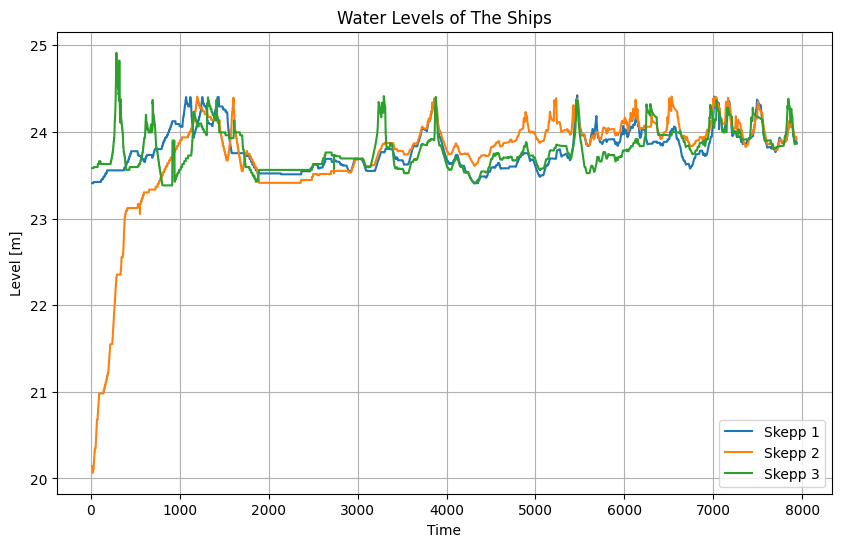

Mean when charging 1:    288.34
Mean when discharging 1: 289.43
Mean when charging 2:    304.33
Mean when discharging 2: 299.0
Mean when charging 3:    271.76
Mean when discharging 3: 246.64


In [250]:
# Plot all data

# Define the layers to extract
layers = [0, 3, 7, 11, 15, 19, 23]

# Extract the layers for skepp1_temp
layer_matrix1 = extract_layers(skepp1_temp, layers)
layer_matrix2 = extract_layers(skepp2_temp, layers)
layer_matrix3 = extract_layers(skepp3_temp, layers)


print(len(layer_matrix1), len(temp_time))

plt.figure(figsize=(12, 10))
# Plot layers over time for skepp1_temp
plt.subplot(3, 1, 1)
for i, layer in enumerate(layers):
    plt.plot(temp_time, layer_matrix1[:, i], label=f'{layer+1} m')
plt.ylabel('Temperature [°C]')
plt.title('Ship 1')
plt.legend()
plt.grid(True)

# Plot layers over time for skepp2_temp
plt.subplot(3, 1, 2)
for i, layer in enumerate(layers):
    plt.plot(temp_time, layer_matrix2[:, i], label=f'{layer+1} m')
plt.ylabel('Temperature [°C]')
plt.title('Ship 2')
plt.legend()
plt.grid(True)

# Plot layers over time for skepp3_temp
plt.subplot(3, 1, 3)
for i, layer in enumerate(layers):
    plt.plot(temp_time, layer_matrix3[:, i], label=f'{layer+1} m')
plt.xlabel('Date')
plt.ylabel('Temperature [°C]')
plt.title('Ship 3')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.suptitle('Temperature Distribution Across Layers Over Time For All Ships', fontsize=16, y=1.02)
#plt.savefig('storage_temp.png', dpi=300, bbox_inches='tight')
plt.show()

# Levels of the ships
plt.figure(figsize=(10, 6))
plt.plot(df_levels['Skepp 1 [m]'], label='Skepp 1')
plt.plot(df_levels['Skepp 2 [m]'], label='Skepp 2')
plt.plot(df_levels['Skepp 3 [m]'], label='Skepp 3')
plt.title('Water Levels of The Ships')
plt.xlabel('Time')
plt.ylabel('Level [m]')
plt.legend()
plt.grid()
#plt.savefig('water levels.png', dpi=300, bbox_inches='tight')
plt.show()


binary_power1 = df_power['Skepp 1 - Effekt [MW]'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
binary_power2 = df_power['Skepp 2 - Effekt [MW]'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
binary_power3 = df_power['Skepp 3 - Effekt [MW]'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# Align the indices of binary_power2 with df_flow
binary_power1_aligned = binary_power1.reindex(df_flow.index, fill_value=0)
binary_power2_aligned = binary_power2.reindex(df_flow.index, fill_value=0)
binary_power3_aligned = binary_power3.reindex(df_flow.index, fill_value=0)

mean_positive1 = df_flow['Q - fjärrvatten - 1'][binary_power1_aligned > 0].mean()
mean_negative1 = df_flow['Q - fjärrvatten - 1'][binary_power1_aligned < 0].mean()
mean_positive2 = df_flow['Q - fjärrvatten - 2'][binary_power2_aligned > 0].mean()
mean_negative2 = df_flow['Q - fjärrvatten - 2'][binary_power2_aligned < 0].mean()
mean_positive3 = df_flow['Q - fjärrvatten - 3'][binary_power3_aligned > 0].mean()
mean_negative3 = df_flow['Q - fjärrvatten - 3'][binary_power3_aligned < 0].mean()

print(f"Mean when charging 1:    {round(mean_positive1, 2)}")
print(f"Mean when discharging 1: {round(mean_negative1, 2)}")
print(f"Mean when charging 2:    {round(mean_positive2, 2)}")
print(f"Mean when discharging 2: {round(mean_negative2, 2)}")
print(f"Mean when charging 3:    {round(mean_positive3, 2)}")
print(f"Mean when discharging 3: {round(mean_negative3, 2)}")



# Plot the heat exchanger data for all 3 ships
fig, axs = plt.subplots(3, 3, figsize=(18, 12))

# First row - Skepp 1
axs[0, 0].plot(df_flow['T - lagervatten - kall - 1'], label='T - Storage side - Cold')
axs[0, 0].plot(df_flow['T - fjärrvatten - kall - 1'], label='T - District side - Cold')
axs[0, 0].set_title('Skepp 1 - Temperature - Cold Water')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Temperature [°C]')

axs[0, 1].plot(df_flow['T - lagervatten - varm - 1'], label='T - Storage side - Hot')
axs[0, 1].plot(df_flow['T - fjärrvatten - varm - 1'], label='T - District side - Hot')
axs[0, 1].set_title('Skepp 1 - Temperature - Hot Water')
axs[0, 1].legend()
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('Temperature [°C]')

axs[0, 2].plot(df_flow['Q - lagervatten - 1'], label='Q - Storage side')
axs[0, 2].plot(df_flow['Q - fjärrvatten - 1'], label='Q - District side')
axs[0, 2].set_title('Skepp 1 - Flow')
axs[0, 2].legend()
axs[0, 2].set_xlabel('Time')
axs[0, 2].set_ylabel('Flow [m³/h]')

# Second row - Skepp 2
axs[1, 0].plot(df_flow['T - lagervatten - kall - 2'], label='T - Storage side - Cold')
axs[1, 0].plot(df_flow['T - fjärrvatten - kall - 2'], label='T - District side - Cold')
axs[1, 0].set_title('Skepp 2 - Temperature - Cold Water')
axs[1, 0].legend()
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Temperature [°C]')

axs[1, 1].plot(df_flow['T - lagervatten - varm - 2'], label='T - Storage side - Hot')
axs[1, 1].plot(df_flow['T - fjärrvatten - varm - 2'], label='T - District side - Hot')
axs[1, 1].set_title('Skepp 2 - Temperature - Hot Water')
axs[1, 1].legend()
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('Temperature [°C]')

axs[1, 2].plot(replace_odd_datapoints(df_flow['Q - lagervatten - 2'].values.reshape(-1, 1), threshold=700, step=1)[0].flatten(), label='Q - Storage side')
axs[1, 2].plot(df_flow['Q - fjärrvatten - 2'], label='Q - District side')
axs[1, 2].plot(binary_power2*100 + 300, label='charge/discharge power')
axs[1, 2].set_title('Skepp 2 - Flow')
axs[1, 2].legend()
axs[1, 2].set_xlabel('Time')
axs[1, 2].set_ylabel('Flow [m³/h]')

# Third row - Skepp 3
axs[2, 0].plot(df_flow['T - lagervatten - kall - 3'], label='T - Storage side - Cold')
axs[2, 0].plot(df_flow['T - fjärrvatten - kall - 3'], label='T - District side - Cold')
axs[2, 0].set_title('Skepp 3 - Temperature - Cold Water')
axs[2, 0].legend()
axs[2, 0].set_xlabel('Time')
axs[2, 0].set_ylabel('Temperature [°C]')

axs[2, 1].plot(df_flow['T - lagervatten - varm - 3'], label='T - Storage side - Hot')
axs[2, 1].plot(df_flow['T - fjärrvatten - varm - 3'], label='T - District side - Hot')
axs[2, 1].set_title('Skepp 3 - Temperature - Hot Water')
axs[2, 1].legend()
axs[2, 1].set_xlabel('Time')
axs[2, 1].set_ylabel('Temperature [°C]')

axs[2, 2].plot(df_flow['Q - lagervatten - 3'], label='Q - Storage side')
axs[2, 2].plot(df_flow['Q - fjärrvatten - 3'], label='Q - District side')
axs[2, 2].set_title('Skepp 3 - Flow')
axs[2, 2].legend()
axs[2, 2].set_xlabel('Time')
axs[2, 2].set_ylabel('Flow [m³/h]')

plt.tight_layout()
for ax_row in axs:
    for ax in ax_row:
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.suptitle('Temperature and Flow Data For Each Ship', fontsize=16, y=1.02)
#plt.savefig('heat exchanger data.png', dpi=300, bbox_inches='tight')
plt.show()


# Bedrock  temperatures

# Calculate the temperature of the ship at level 19, 18.5 meter height
skepp2_temp_level18 = level_temperature(skepp2_temp, 18)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# First plot: Temperature of the Bedrock Over Time
axs[0].plot(temp_time, skepp2_temp_level18, label='0m') 
axs[0].plot(df_berg_temp['time'], df_berg_temp['0.2m'], label='0.2m')
axs[0].plot(df_berg_temp['time'], df_berg_temp['2.6m'], label='2.6m')
axs[0].plot(df_berg_temp['time'], df_berg_temp['5.1m'], label='5.1m')
axs[0].plot(df_berg_temp['time'], df_berg_temp['7.5m'], label='7.5m')
axs[0].plot(df_berg_temp['time'], df_berg_temp['9.9m'], label='9.9m')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Temperature [°C]')
axs[0].set_title('Temperature of The Bedrock Over Time')
axs[0].legend()
axs[0].grid(True)
axs[0].grid(which='both', linestyle='--', linewidth=0.5)
axs[0].tick_params(axis='x', rotation=45)

# Second plot: Temperature Distribution in the Bedrock
x = np.array([0.2, 2.6, 5.1, 7.5, 9.9])
mountain_temp_dist = np.zeros((len(df_berg_temp), len(x)))  # 5 columns for each depth level
for i in range(100, len(df_berg_temp), 600):  # Iterate every 100th value
    mountain_temp_dist[i] = df_berg_temp.iloc[i, 1:].values
    axs[1].plot(x, mountain_temp_dist[i], label=df_berg_temp['time'].iloc[i].strftime('%Y-%m-%d'))

axs[1].legend()
axs[1].set_xlabel('Depth [m]')
axs[1].set_ylabel('Temperature [°C]')
axs[1].set_title('Temperature Distribution in the Bedrock at Different Depths and Times')
axs[1].set_xticks(x)  # Set xticks to match the x array
axs[1].grid(True)
plt.tight_layout()
#plt.savefig('bedrock_temp.png', dpi=300, bbox_inches='tight')
plt.show()

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.77621298e-02 -5.31044559e-02
 -3.03055766e-04 -2.50336504e-02 -1.71661377e-02 -7.15944385e-03
  2.47637367e-02  3.53616982e-02 -3.79975472e-02  5.30389405e-03
  3.38331757e-02  0.00000000e+00 -2.61883259e-02 -3.51795664e-02
 -6.93245794e-03 -1.72320099e-02 -3.95839881e-03  3.87029371e-02
 -2.01616476e-03 -5.74074020e-02 -9.93833352e-03  2.88146887e-02
 -3.83475304e-03 -2.71497803e-02 -3.29622545e-02 -7.45567074e-02
 -1.22783535e-01 -1.29043797e-01 -1.41327430e-01 -1.21769530e-01
 -1.25533879e-01 -1.64858966e-01 -1.31106668e-01 -1.27466079e-01
 -1.71149761e-01 -1.71395652e-01 -1.52687961e-01 -1.55538505e-01
 -1.77555430e-01 -1.89016457e-01 -1.83995263e-01 -1.93353047e-01
 -2.33044461e-01 -2.17700589e-01 -2.25440764e-01 -2.59163032e-01
 -2.66990303e-01 -3.45846262e-01 -3.71872976e-01 -3.74721049e-01
 -4.00404518e-01 -4.09549413e-01 -4.75579865e-01 -5.07667758e-01
 -6.20949611e-01 -6.57394

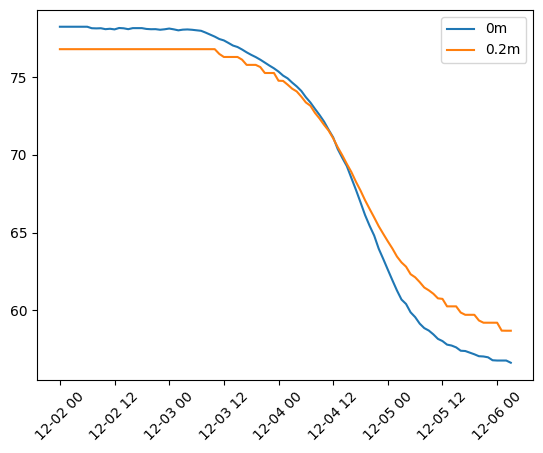

In [320]:
when = slice(4200, 4300)  # Adjust the slice as needed
plt.plot(temp_time[when], skepp2_temp_level18[when], label='0m') 
plt.plot(df_berg_temp['time'].iloc[when], df_berg_temp['0.2m'].iloc[when], label='0.2m')
plt.xticks(rotation=45)
plt.legend()

grad_water = np.gradient(skepp2_temp_level18[when], temp_time_hours[when])
grad_bedrock = np.gradient(df_berg_temp['0.2m'].iloc[when], temp_time_hours[when])
print(grad_water)
print(grad_bedrock)


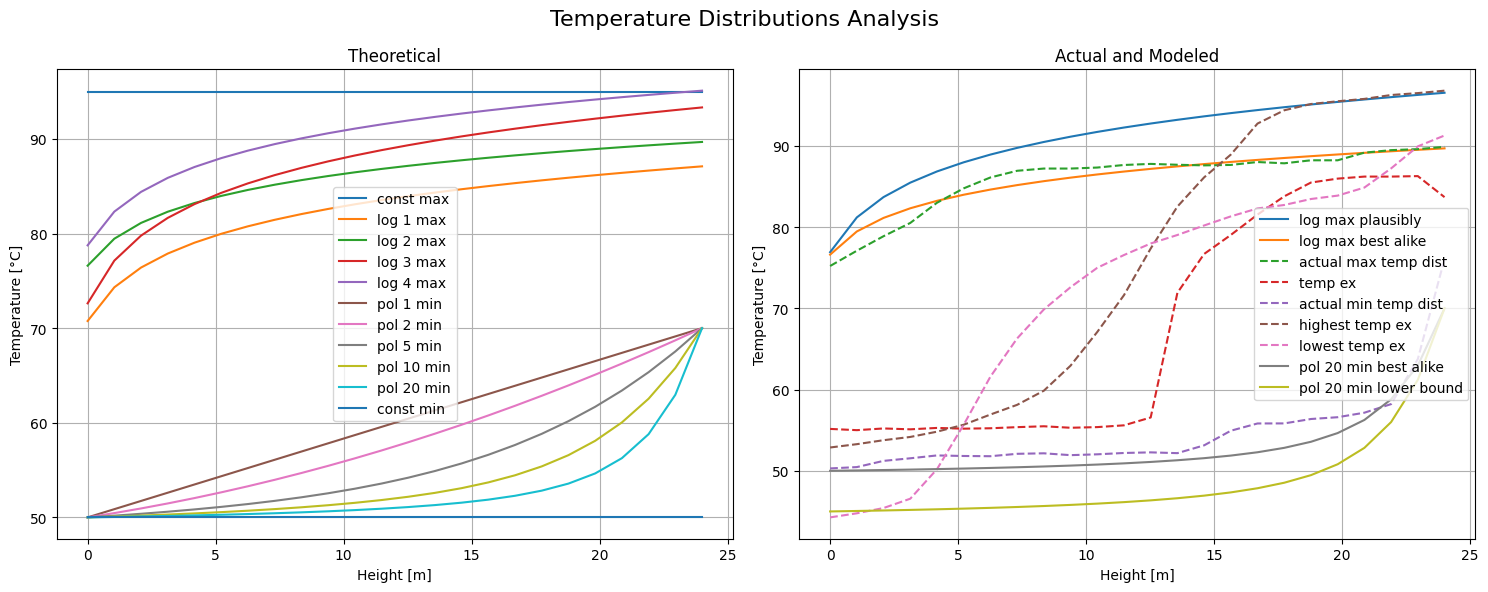

In [224]:

# Test min_temperature_distribution function and plot the result
p_1 = min_temperature_distribution(skepp1_temp[0], 50, 70, 1)
p_2 = min_temperature_distribution(skepp1_temp[0], 50, 70, 2)
p_5 = min_temperature_distribution(skepp1_temp[0], 50, 70, 5)
p_10 = min_temperature_distribution(skepp1_temp[0], 50, 70, 10)
p_0 = min_temperature_distribution(skepp1_temp[0], 50, 45, 0)
p_max = min_temperature_distribution(skepp1_temp[0], 95, 95, 0)
p_min = min_temperature_distribution(skepp1_temp[0], 45, 70, 20)
x = np.linspace(0, len(p_1), len(p_1))


# Find some actual min/max temperature distributions and exemples
act_temp = skepp1_temp[4000]
act_temp_max = find_temp_dist(skepp1_temp, 'max')
act_temp_min = find_temp_dist(skepp1_temp[2000:], 'min')
temp_max_log_dist = min_temperature_distribution(skepp1_temp[0], 78, 97, -1) # actually 95 max but 100 makes the fit better
log_dis_1 = min_temperature_distribution(skepp1_temp[0], 75, 90, -1)
log_dis_2 = min_temperature_distribution(skepp1_temp[0], 83, 98, -1)
temp_best_alike_max_log_dis = min_temperature_distribution(skepp1_temp[0], 80, 92, -1)
temp_best_plausibly_log  = min_temperature_distribution(skepp1_temp[0], 82, 100, -1)
p_best_alike_min = min_temperature_distribution(skepp1_temp[0], 50, 70, 20)

# Find the index of the maximum and minimum temperature in the data
init = 3000
max_temp_index = find_extreme_index(skepp2_temp, 'max')
min_temp_index = find_extreme_index(skepp3_temp[init:], 'min') + init


# Plot the temperature distributions
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # Create side-by-side subplots

axs[0].plot(x, p_max, label='const max')
axs[0].plot(x, log_dis_1, label='log 1 max')
axs[0].plot(x, temp_best_alike_max_log_dis, label='log 2 max')
axs[0].plot(x, temp_max_log_dist, label='log 3 max')
axs[0].plot(x, log_dis_2, label='log 4 max')
axs[0].plot(x, p_1, label='pol 1 min')
axs[0].plot(x, p_2, label='pol 2 min')
axs[0].plot(x, p_5, label='pol 5 min')
axs[0].plot(x, p_10, label='pol 10 min')
axs[0].plot(x, p_best_alike_min, label='pol 20 min')
axs[0].plot(x, p_0, label='const min')
axs[0].set_xlabel('Height [m]')
axs[0].set_ylabel('Temperature [°C]')
axs[0].set_title('Theoretical')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(x, temp_best_plausibly_log, label='log max plausibly')
axs[1].plot(x, temp_best_alike_max_log_dis, label='log max best alike')
axs[1].plot(x, act_temp_max, linestyle='--', label='actual max temp dist')
axs[1].plot(x, act_temp, linestyle='--', label='temp ex')
axs[1].plot(x, act_temp_min, linestyle='--', label='actual min temp dist')
axs[1].plot(x, skepp2_temp[max_temp_index], linestyle='--', label='highest temp ex')
axs[1].plot(x, skepp3_temp[min_temp_index], linestyle='--', label='lowest temp ex')
axs[1].plot(x, p_best_alike_min, label='pol 20 min best alike')
axs[1].plot(x, p_min, label='pol 20 min lower bound')
axs[1].set_xlabel('Height [m]')
axs[1].set_ylabel('Temperature [°C]')
axs[1].set_title('Actual and Modeled')
axs[1].legend()
axs[1].grid(True)

fig.suptitle('Temperature Distributions Analysis', fontsize=16)  # Add a main title

plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust layout to fit the main title
plt.show()


In [225]:
# Thermocline analysis
x = np.linspace(0, 24, 200)
step_function = np.where((x >= 12) & (x <= 85), 1, 0)
logistic_function1 = 1 / (1 + np.exp(-0.5 * (x - 12))) * 40 + 50
logistic_function2 = 1 / (1 + np.exp(-1 * (x - 12))) * 40 + 50
logistic_function3 = 1 / (1 + np.exp(-3 * (x - 12))) * 40 + 50

plt.figure(figsize=(10, 6))
plt.step(x, step_function * 40 + 50, where='mid', linewidth=3, label='Step Function')
plt.plot(x, logistic_function1, label='Logistic Function 1')
plt.plot(x, logistic_function2, label='Logistic Function 2')
plt.plot(x, logistic_function3, label='Logistic Function 3')
plt.ylabel('Temperature [°C]')
plt.xlabel('Height [m]')
plt.title('Thermocline Temperature Distributions')
plt.legend()
plt.grid(True)

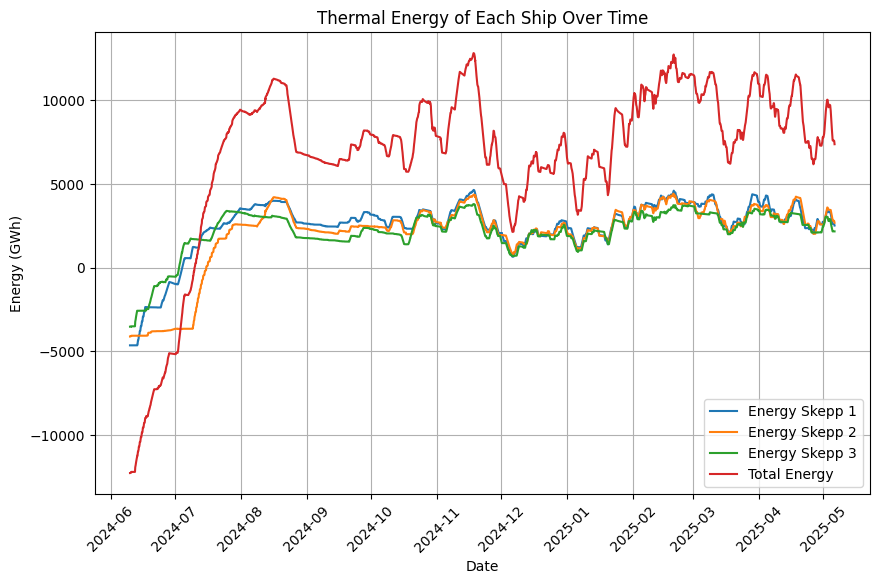

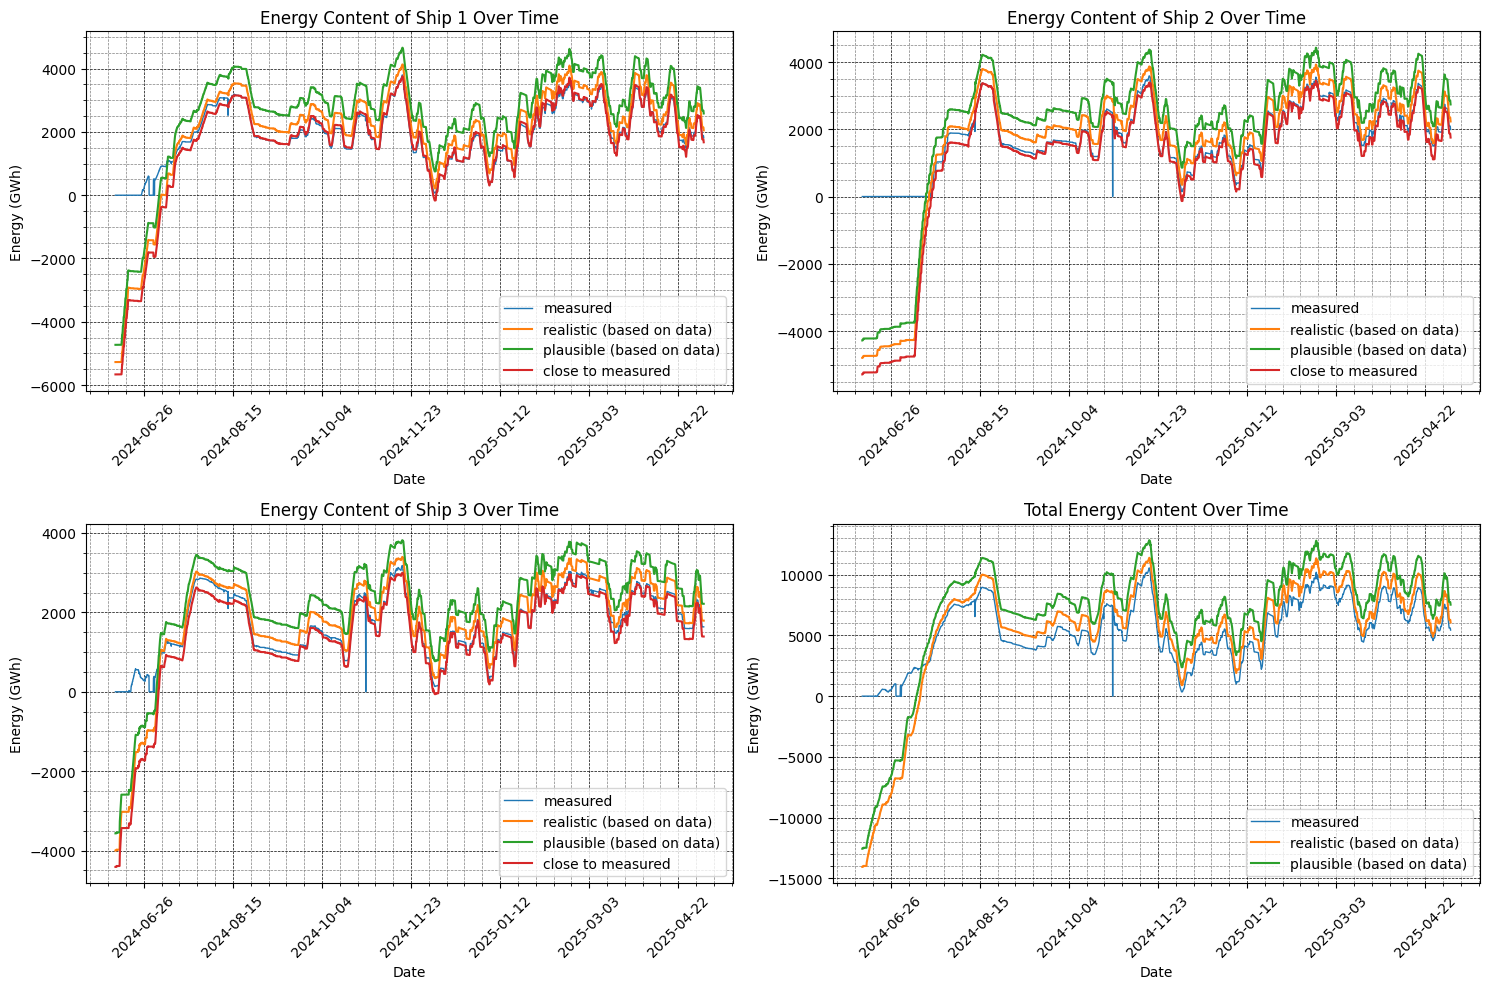

In [226]:
# Energy calculations

# Calculate the thermal energy for each ship
energy_skepp1 = thermal_energy_new(t_bot_min,t_top_min, skepp1_temp, skepp1_sep_vol_y, df_levels['Skepp 1 [m]'], top_volume1,20)*1000
energy_skepp2 = thermal_energy_new(t_bot_min,t_top_min, skepp2_temp, skepp2_sep_vol_y, df_levels['Skepp 2 [m]'], top_volume2,20)*1000
energy_skepp3 = thermal_energy_new(t_bot_min,t_top_min, skepp3_temp, skepp3_sep_vol_y, df_levels['Skepp 3 [m]'], top_volume3,20)*1000

# Linear fit between the values at indices 453 and 513
energy_skepp1[453:514] = np.linspace(energy_skepp1[452], energy_skepp1[513], 513 - 453 + 1)
energy_skepp2[453:514] = np.linspace(energy_skepp2[452], energy_skepp2[513], 513 - 453 + 1)
energy_skepp3[453:514] = np.linspace(energy_skepp3[452], energy_skepp3[513], 513 - 453 + 1)

# Adjust the energy for ship 2
# Calculate the difference between the new and old energy values for ship 2
energy_skepp2_diff = (thermal_energy_new(t_bot_min,t_top_min, skepp2_temp, skepp2_sep_vol_y, df_levels['Skepp 2 [m]'], top_volume2,20) - thermal_energy_new(t_bot_min,t_top_min, skepp2_temp, skepp2_sep_vol_y, df_levels['Skepp 2 [m]'], top_volume2,2))[1450:1770]*1000
adjusted_1450 = replace_odd_datapoints(df_power['Skepp 2 Energi [MWh]'].values.reshape(-1, 1), threshold=300)[0].flatten()

# adjust energy for ship 2
energy_skepp2[1450:1770] = adjusted_1450[1450:1770] + energy_skepp2_diff.mean()
energy_skepp2[1430:1530] = adjusted_1450[1430:1530] * np.linspace(0.90, 1, 100) + energy_skepp2_diff.mean()



plt.figure(figsize=(10, 6))
plt.plot(temp_time, energy_skepp1, label='Energy Skepp 1')
plt.plot(temp_time, energy_skepp2, label='Energy Skepp 2')
plt.plot(temp_time, energy_skepp3, label='Energy Skepp 3')
plt.plot(temp_time, energy_skepp1 + energy_skepp2 + energy_skepp3, label='Total Energy')
plt.xlabel('Date')
plt.ylabel('Energy (GWh)')
plt.title('Thermal Energy of Each Ship Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


# Calcalute different energy values depending on polynomial degree
energy_skepp1_pol1 = thermal_energy(t_bot_min,t_top_min, skepp1_temp, skepp1_sep_vol_y,1)*1000
energy_skepp1_pol2 = thermal_energy(t_bot_min,t_top_min, skepp1_temp, skepp1_sep_vol_y,2)*1000
energy_skepp1_pol3 = thermal_energy(t_bot_min,t_top_min, skepp1_temp, skepp1_sep_vol_y,10)*1000
energy_skepp1_pol5 = thermal_energy(t_bot_min,t_top_min, skepp1_temp, skepp1_sep_vol_y,20)*1000
energy_skepp1_pol4 = thermal_energy(t_bot_min,t_bot_min, skepp1_temp, skepp1_sep_vol_y,0)*1000

# realistic, plausible and extra realistic energy calc
energy_skepp1_realistic = thermal_energy(50,70, skepp1_temp, skepp1_sep_vol_y,20)*1000
energy_skepp1_plausible = thermal_energy(45,70, skepp1_temp, skepp1_sep_vol_y,20)*1000

energy_skepp2_realistic = thermal_energy(50,70, skepp2_temp, skepp2_sep_vol_y,20)*1000
energy_skepp2_plausible = thermal_energy(45,70, skepp2_temp, skepp2_sep_vol_y,20)*1000
energy_skepp2_comp = thermal_energy(50,70, skepp2_temp, skepp2_sep_vol_y,4)*1000

# adjust for ship 2
energy_skepp2_realistic[1450:1770] = adjusted_1450[1450:1770] + energy_skepp2_diff.mean()/2
energy_skepp2_realistic[1430:1530] = adjusted_1450[1430:1530] * np.linspace(0.90, 1, 100) + energy_skepp2_diff.mean()/2

energy_skepp2_plausible[1450:1770] = adjusted_1450[1450:1770] + energy_skepp2_diff.mean()
energy_skepp2_plausible[1430:1530] = adjusted_1450[1430:1530] * np.linspace(0.90, 1, 100) + energy_skepp2_diff.mean()

energy_skepp2_comp[1450:1770] = adjusted_1450[1450:1770]
energy_skepp2_comp[1430:1530] = adjusted_1450[1430:1530] * np.linspace(0.90, 1, 100)

energy_skepp3_realistic = thermal_energy(50,70, skepp3_temp, skepp3_sep_vol_y,20)*1000
energy_skepp3_plausible = thermal_energy(45,70, skepp3_temp, skepp3_sep_vol_y,20)*1000
energy_skepp3_comp = thermal_energy(50,70, skepp3_temp, skepp3_sep_vol_y,4)*1000


# Plot the energy of Skepp 1 over time
plt.figure(figsize=(10, 6))
plt.plot(temp_time, df_power['Skepp 1 Energi [MWh]'], linewidth = 3, label='measured')
plt.plot(temp_time, energy_skepp1_pol1, label='pol 1')
plt.plot(temp_time, energy_skepp1_pol2, label='pol 2')
plt.plot(temp_time, energy_skepp1_pol3, label='pol 10')
plt.plot(temp_time, energy_skepp1_pol5, label='pol 20')
plt.plot(temp_time, energy_skepp1_pol4, label='constant min45')
plt.xlabel('Date')
plt.ylabel('Energy (GWh)')
plt.title('Energy Content of Skepp 1 Over Time')
plt.legend()
plt.grid(True)
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
# Loop through each subplot and apply the settings
for ax_row in axs:
	for ax in ax_row:
		ax.xaxis.set_major_locator(AutoLocator())
		ax.xaxis.set_minor_locator(AutoMinorLocator())
		ax.yaxis.set_major_locator(AutoLocator())
		ax.yaxis.set_minor_locator(AutoMinorLocator())
		# Enable both major and minor grid lines
		ax.grid(which='major', color='black', linestyle='-', linewidth=0.75)
		ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)


# Plot for Skepp 1
axs[0, 0].plot(temp_time, df_power['Skepp 1 Energi [MWh]'] , linewidth=1, label='measured')
axs[0, 0].plot(temp_time, energy_skepp1_realistic, label='realistic (based on data)')
axs[0, 0].plot(temp_time, energy_skepp1_plausible, label='plausible (based on data)')
axs[0, 0].plot(temp_time, energy_skepp1_pol2, label='close to measured')
axs[0, 0].set_title('Energy Content of Ship 1 Over Time')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Energy (GWh)')
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 0].minorticks_on()
axs[0, 0].grid(which='both', linestyle='--', linewidth=0.5)
axs[0, 0].tick_params(axis='x', rotation=45)

# Plot for Skepp 2
axs[0, 1].plot(temp_time, df_power['Skepp 2 Energi [MWh]'] , linewidth=1, label='measured')
axs[0, 1].plot(temp_time, energy_skepp2_realistic, label='realistic (based on data)')
axs[0, 1].plot(temp_time, energy_skepp2_plausible, label='plausible (based on data)')
axs[0, 1].plot(temp_time, energy_skepp2_comp, label='close to measured')
axs[0, 1].set_title('Energy Content of Ship 2 Over Time')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Energy (GWh)')
axs[0, 1].legend()
axs[0, 1].grid(True)
axs[0, 1].minorticks_on()
axs[0, 1].grid(which='both', linestyle='--', linewidth=0.5)
axs[0, 1].tick_params(axis='x', rotation=45)

# Plot for Skepp 3
axs[1, 0].plot(temp_time, df_power['Skepp 3 Energi [MWh]'] , linewidth=1, label='measured')
axs[1, 0].plot(temp_time, energy_skepp3_realistic, label='realistic (based on data)')
axs[1, 0].plot(temp_time, energy_skepp3_plausible, label='plausible (based on data)')
axs[1, 0].plot(temp_time, energy_skepp3_comp, label='close to measured')
axs[1, 0].set_title('Energy Content of Ship 3 Over Time')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Energy (GWh)')
axs[1, 0].legend()
axs[1, 0].grid(True)
axs[1, 0].minorticks_on()
axs[1, 0].grid(which='both', linestyle='--', linewidth=0.5)
axs[1, 0].tick_params(axis='x', rotation=45)

# Plot for Total Energy
axs[1, 1].plot(temp_time, df_power['Total Energi [MWh]'], linewidth=1, label='measured')
axs[1, 1].plot(temp_time, energy_skepp1_realistic + energy_skepp2_realistic + energy_skepp3_realistic, label='realistic (based on data)')
axs[1, 1].plot(temp_time, energy_skepp1_plausible + energy_skepp2_plausible + energy_skepp3_plausible, label='plausible (based on data)')
axs[1, 1].set_title('Total Energy Content Over Time')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Energy (GWh)')
axs[1, 1].legend()
axs[1, 1].grid(True)
axs[1, 1].minorticks_on()
axs[1, 1].grid(which='both', linestyle='--', linewidth=0.5)
axs[1, 1].tick_params(axis='x', rotation=45)

# Format x-axis to show full date
for ax in axs.ravel():
	ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
	
plt.tight_layout()
plt.show()

In [227]:
# Theoretical max? According to data it is above 90 and below 50, more likely 95 and 45
t_theo_max = np.full_like(temp_max_log_dist, 90)
theoretical_e1 = np.sum(thermal_energy(50, 50, t_theo_max, skepp1_sep_vol_y, 0))
theoretical_e2 = np.sum(thermal_energy(50, 50, t_theo_max, skepp2_sep_vol_y, 0))
theoretical_e3 = np.sum(thermal_energy(50, 50, t_theo_max, skepp3_sep_vol_y, 0))
print(f'Theoretical capacity 50-90 const:                                                {round(theoretical_e1 + theoretical_e2 + theoretical_e3,2)} GWh')

# Theoretical max? According to data it is above 90 and below 50, more likely 95 and 45
t_theo_max_H = np.full_like(temp_max_log_dist, 95)
theoretical_e1_H = np.sum(thermal_energy(45, 45, t_theo_max_H, skepp1_sep_vol_y, 0))
theoretical_e2_H = np.sum(thermal_energy(45, 45, t_theo_max_H, skepp2_sep_vol_y, 0))
theoretical_e3_H = np.sum(thermal_energy(45, 45, t_theo_max_H, skepp3_sep_vol_y, 0))
print(f'Theoretical capacity 45-95 const:                                                {round(theoretical_e1_H + theoretical_e2_H + theoretical_e3_H,2)} GWh')

# Theoretical max? According to data it is above 90 and below 50, more likely 95 and 45
t_theo_max_H = np.full_like(temp_max_log_dist, 95)
theoretical_e1_HL = np.sum(thermal_energy(50, 50, t_theo_max_H, skepp1_sep_vol_y, 0))
theoretical_e2_HL = np.sum(thermal_energy(50, 50, t_theo_max_H, skepp2_sep_vol_y, 0))
theoretical_e3_HL = np.sum(thermal_energy(50, 50, t_theo_max_H, skepp3_sep_vol_y, 0))
print(f'Theoretical capacity 50-95 const:                                                {round(theoretical_e1_HL + theoretical_e2_HL + theoretical_e3_HL,2)} GWh')

# Simple theoretical max, 40 degrees diff (difference is c and rho temperature dependency)
theoretical_simp1 = 4186*1000*np.sum(skepp1_sep_vol_y)*(90-50)/(3600*1e9)
theoretical_simp2 = 4186*1000*np.sum(skepp2_sep_vol_y)*(90-50)/(3600*1e9)
theoretical_simp3 = 4186*1000*np.sum(skepp3_sep_vol_y)*(90-50)/(3600*1e9)
print(f'Theoretical capacity 50-90 cosnst (no rho and c T dependence):                   {round(theoretical_simp1 + theoretical_simp2 + theoretical_simp3,2)} GWh')

# Simple theoretical max, 50 degrees diff (difference is c and rho temperature dependency)
theoretical_simp1_H = 4186*1000*np.sum(skepp1_sep_vol_y)*(95-45)/(3600*1e9)
theoretical_simp2_H = 4186*1000*np.sum(skepp2_sep_vol_y)*(95-45)/(3600*1e9)
theoretical_simp3_H = 4186*1000*np.sum(skepp3_sep_vol_y)*(95-45)/(3600*1e9)
print(f'Theoretical capacity 45-95 const (no rho and c T dependence):                    {round(theoretical_simp1_H + theoretical_simp2_H + theoretical_simp3_H,2)} GWh')

# Simple theoretical max, 50 degrees diff (difference is c and rho temperature dependency)
theoretical_simp1_HL = 4186*1000*np.sum(skepp1_sep_vol_y)*(95-50)/(3600*1e9)
theoretical_simp2_HL = 4186*1000*np.sum(skepp2_sep_vol_y)*(95-50)/(3600*1e9)
theoretical_simp3_HL = 4186*1000*np.sum(skepp3_sep_vol_y)*(95-50)/(3600*1e9)
print(f'Theoretical capacity 50-95 const (no rho and c T dependence):                    {round(theoretical_simp1_HL + theoretical_simp2_HL + theoretical_simp3_HL,2)} GWh')

print('')

# With max plausible temperature distribution
log_distrubution_e1_H = np.sum(thermal_energy(45, 70, temp_best_plausibly_log, skepp1_sep_vol_y, 20))
log_distrubution_e2_H = np.sum(thermal_energy(45, 70, temp_best_plausibly_log, skepp2_sep_vol_y, 20))
log_distrubution_e3_H = np.sum(thermal_energy(45, 70, temp_best_plausibly_log, skepp3_sep_vol_y, 20))
print(f'Energy with possible max log distribution & p20 min (45-95) (plausibly):         {round(log_distrubution_e1_H + log_distrubution_e2_H + log_distrubution_e3_H,2)} GWh')

# With max plausible temperature distribution
log_distrubution_e1 = np.sum(thermal_energy(50, 70, temp_best_plausibly_log, skepp1_sep_vol_y, 20))
log_distrubution_e2 = np.sum(thermal_energy(50, 70, temp_best_plausibly_log, skepp2_sep_vol_y, 20))
log_distrubution_e3 = np.sum(thermal_energy(50, 70, temp_best_plausibly_log, skepp3_sep_vol_y, 20))
print(f'Energy with possible max log distribution & p20 min (50-95) (plausibly):         {round(log_distrubution_e1+log_distrubution_e2+log_distrubution_e3,2)} GWh')

print('')

# With actual max and min distributions (fitted for actual temp)
log_distrubution_e1 = np.sum(thermal_energy(50, 70, temp_best_alike_max_log_dis, skepp1_sep_vol_y, 20))
log_distrubution_e2 = np.sum(thermal_energy(50, 70, temp_best_alike_max_log_dis, skepp2_sep_vol_y, 20))
log_distrubution_e3 = np.sum(thermal_energy(50, 70, temp_best_alike_max_log_dis, skepp3_sep_vol_y, 20))
print(f'Energy with log distribution & p20 min (50-90) (fitted for actual temp):         {round(log_distrubution_e1+log_distrubution_e2+log_distrubution_e3,2)} GWh')


# Actual max historically, with acutal max
act_energy_max1 = np.sum(thermal_energy(50, 70, act_temp_max, skepp1_sep_vol_y, 20))
act_energy_max2 = np.sum(thermal_energy(50, 70, act_temp_max, skepp2_sep_vol_y, 20))
act_energy_max3 = np.sum(thermal_energy(50, 70, act_temp_max, skepp3_sep_vol_y, 20))

print(f'Actual max capacity calculated (historically) with actual max                    {round(act_energy_max1 + act_energy_max2 + act_energy_max3,2)} GWh')
print(f'Actual max capacity measured (historically)                                      {round(max(df_power['Total Energi [MWh]'])/1000,2)} GWh')



Theoretical capacity 50-90 const:                                                13.76 GWh
Theoretical capacity 45-95 const:                                                17.17 GWh
Theoretical capacity 50-95 const:                                                15.45 GWh
Theoretical capacity 50-90 cosnst (no rho and c T dependence):                   14.19 GWh
Theoretical capacity 45-95 const (no rho and c T dependence):                    17.74 GWh
Theoretical capacity 50-95 const (no rho and c T dependence):                    15.97 GWh

Energy with possible max log distribution & p20 min (45-95) (plausibly):         14.66 GWh
Energy with possible max log distribution & p20 min (50-95) (plausibly):         13.21 GWh

Energy with log distribution & p20 min (50-90) (fitted for actual temp):         11.45 GWh
Actual max capacity calculated (historically) with actual max                    11.44 GWh
Actual max capacity measured (historically)                                      10.57 G

In [228]:
# Take the cumulative sum of the charge and discharge and adjust the energy, keep the same shape
charge_measured1 = df_power['Skepp 1 - Effekt [MW]'].apply(lambda x: x if x > 0 else 0)
cum_charge_measured1 = charge_measured1.cumsum()
discharge_measured1 = df_power['Skepp 1 - Effekt [MW]'].apply(lambda x: x if x < 0 else 0)
cum_discharge_measured1 = discharge_measured1.cumsum()

# Take the cumulative sum of the charge and discharge and adjust the energy
charge_measured2 = df_power['Skepp 2 - Effekt [MW]'].apply(lambda x: x if x > 0 else 0)
cum_charge_measured2 = charge_measured2.cumsum()
discharge_measured2 = df_power['Skepp 2 - Effekt [MW]'].apply(lambda x: x if x < 0 else 0)
cum_discharge_measured2 = discharge_measured2.cumsum()

# Adjust the energy for ship 2, where some charging has not been accounted for 
power2, charge_calc2, discharge_calc2, losses2, steady_losses2 = calculate_power(energy_skepp2, temp_time_hours, charge_measured2, discharge_measured2)

when = slice(0, 705)
charge_measured2_adjusted = np.copy(charge_measured2)

charge_measured2_adjusted[when] = np.where(power2[when] > 0, power2[when], charge_measured2_adjusted[when])
cum_charge_measured2_adjust = charge_measured2_adjusted.cumsum()
charge_measured2_adjusted = pd.DataFrame(charge_measured2_adjusted, columns=['Charge Measured 2 Adjusted'])
charge_measured2_adjusted = charge_measured2_adjusted['Charge Measured 2 Adjusted']
df_power['Skepp 2 - Effekt [MW]'].iloc[0:700] = charge_measured2_adjusted[0:700]

power2, charge_calc2, discharge_calc2, losses2, steady_losses2 = calculate_power(energy_skepp2, temp_time_hours, charge_measured2_adjusted, discharge_measured2)


# Take the cumulative sum of the charge and discharge and adjust the energy
charge_measured3 = df_power['Skepp 3 - Effekt [MW]'].apply(lambda x: x if x > 0 else 0)
cum_charge_measured3 = charge_measured3.cumsum()
discharge_measured3 = df_power['Skepp 3 - Effekt [MW]'].apply(lambda x: x if x < 0 else 0)
cum_discharge_measured3 = discharge_measured3.cumsum()

# Calculate the power of the ships
power1, charge_calc1, discharge_calc1, losses1, steady_losses1 = calculate_power(energy_skepp1, temp_time_hours, charge_measured1, discharge_measured1)
power2, charge_calc2, discharge_calc2, losses2, steady_losses2 = calculate_power(energy_skepp2, temp_time_hours, charge_measured2, discharge_measured2)
power3, charge_calc3, discharge_calc3, losses3, steady_losses3 = calculate_power(energy_skepp3, temp_time_hours, charge_measured3, discharge_measured3)



Ratio
Ratio stor/dist 1:         1.51
Ratio stor/dist 2:         1.24
Ratio stor/dist 3:         1.3

Ratio WO 0
Rartio stor/dist 1:        1.26
Rartio stor/dist 2:        1.17
Rartio stor/dist 3:        1.19

Discharge:
Ratio between calc/meas 1: 0.92
Ratio between calc/meas 2: 0.99
Ratio between calc/meas 3: 0.95

Charge:
Ratio between calc/meas 1: 0.86
Ratio between calc/meas 2: 0.89
Ratio between calc/meas 3: 0.88

Mean charge/discharge
Mean discharge 1:         -20.4
Mean discharge 2:         -20.8
Mean discharge 3:         -19.39
Mean charge 1:            19.01
Mean charge 2:            19.62
Mean charge 3:            19.86


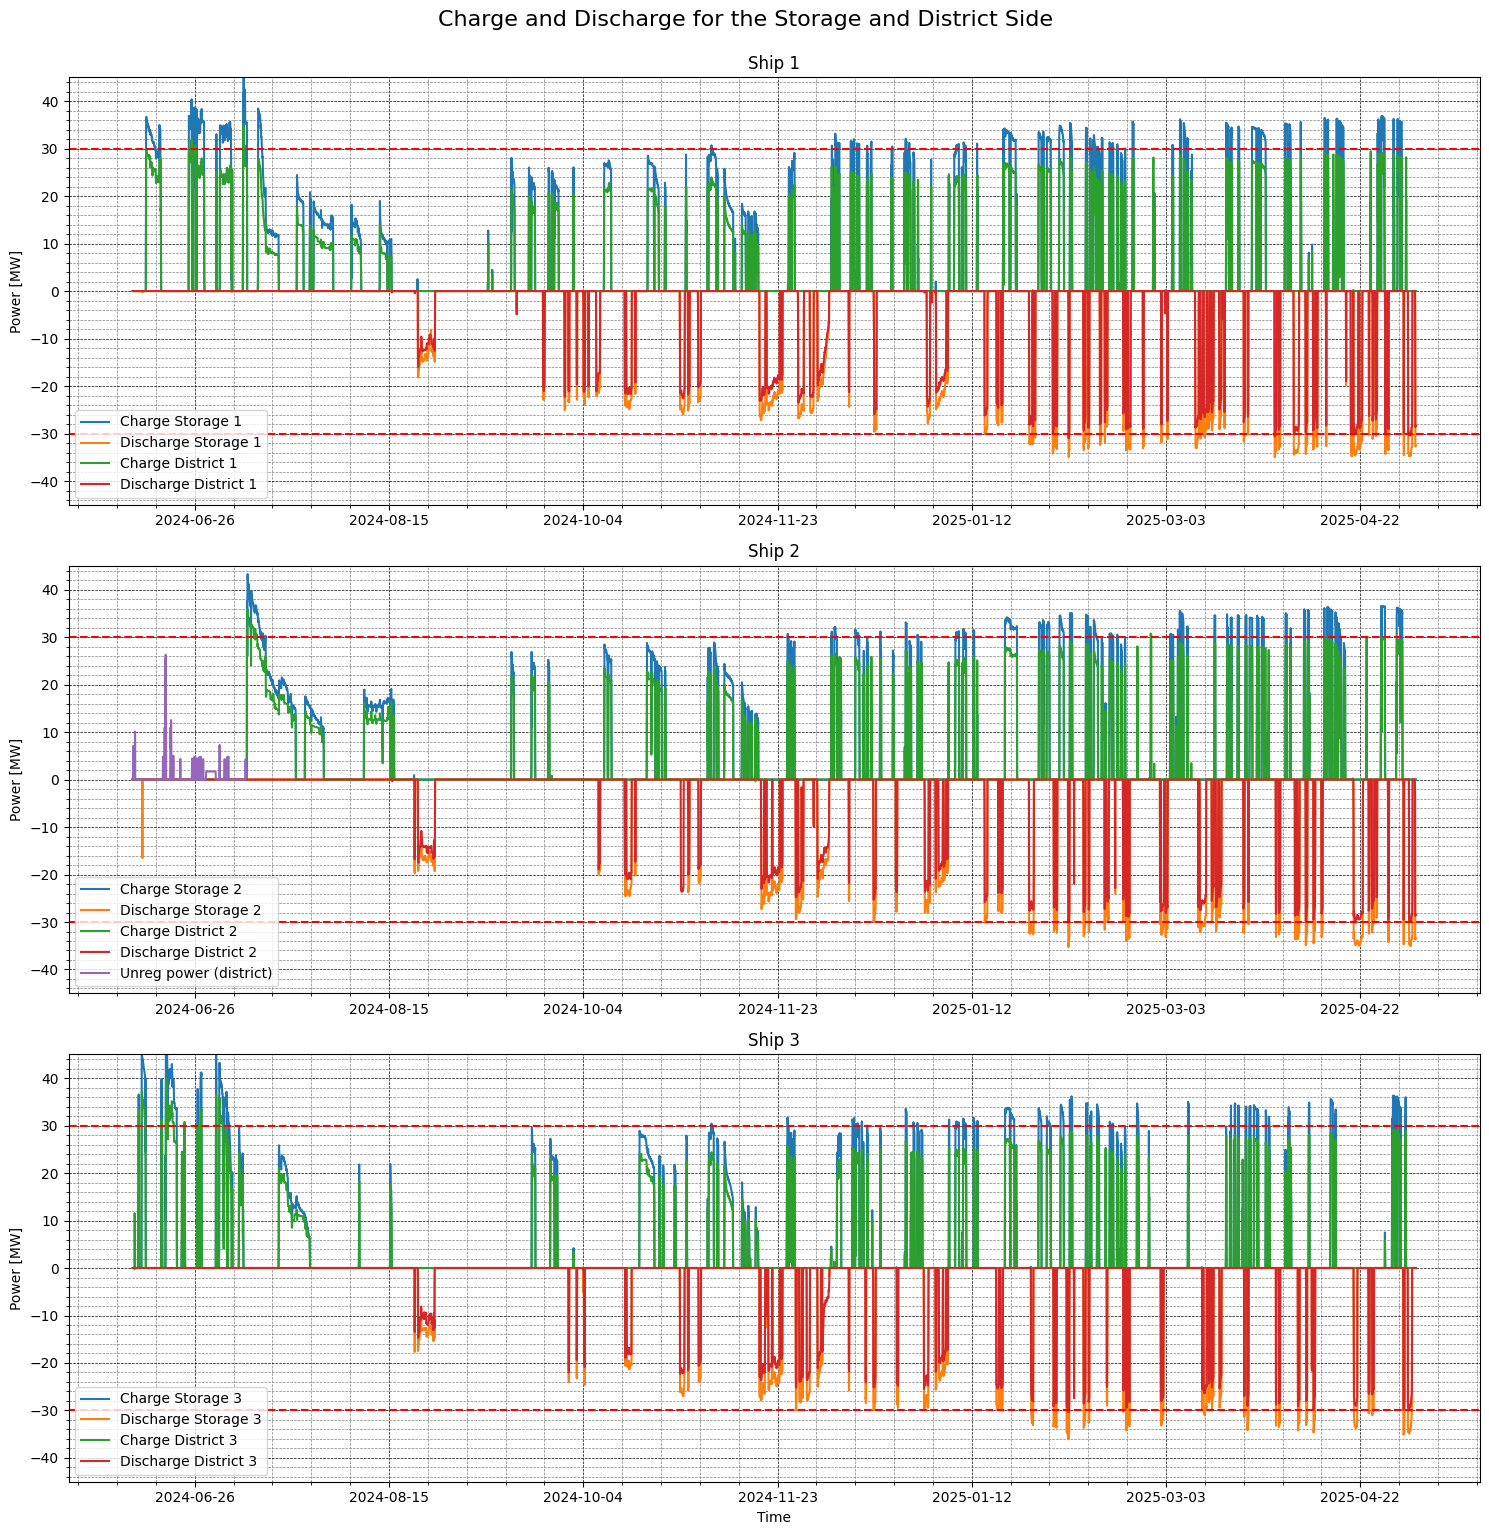

In [229]:
# Calculate charging and discharging powers

# Calcualte the power of the heat exchangers
power_storage_side1 = power_heat_exchanger(df_flow['T - lagervatten - kall - 1'], df_flow['T - lagervatten - varm - 1'], df_flow['Q - lagervatten - 1'])
power_district_side1 = power_heat_exchanger(df_flow['T - fjärrvatten - kall - 1'], df_flow['T - fjärrvatten - varm - 1'], df_flow['Q - fjärrvatten - 1'])

power_storage_side2 = power_heat_exchanger(df_flow['T - lagervatten - kall - 2'], df_flow['T - lagervatten - varm - 2'], df_flow['Q - lagervatten - 2'])
power_district_side2 = power_heat_exchanger(df_flow['T - fjärrvatten - kall - 2'], df_flow['T - fjärrvatten - varm - 2'], df_flow['Q - fjärrvatten - 2'])

power_storage_side3 = power_heat_exchanger(df_flow['T - lagervatten - kall - 3'], df_flow['T - lagervatten - varm - 3'], df_flow['Q - lagervatten - 3'])
power_district_side3 = power_heat_exchanger(df_flow['T - fjärrvatten - kall - 3'], df_flow['T - fjärrvatten - varm - 3'], df_flow['Q - fjärrvatten - 3'])


# Change "power_storage_side1" to be negative where df_power['Skepp 1 - Effekt [MW]'] is negative
power_storage_side1[df_power['Skepp 1 - Effekt [MW]'].astype(float).values < 0] *= -1
power_storage_side2[df_power['Skepp 2 - Effekt [MW]'].astype(float).values < 0] *= -1
power_storage_side3[df_power['Skepp 3 - Effekt [MW]'].astype(float).values < 0] *= -1

# Change "power_district_side1" to be negative where df_power['Skepp 1 - Effekt [MW]'] is negative
power_district_side1[df_power['Skepp 1 - Effekt [MW]'].astype(float).values < 0] *= -1
power_district_side2[df_power['Skepp 2 - Effekt [MW]'].astype(float).values < 0] *= -1
power_district_side3[df_power['Skepp 3 - Effekt [MW]'].astype(float).values < 0] *= -1

# Create a DataFrame for all the powers on the district side
df_power_district = pd.DataFrame({
    'Time': df_flow['date'],
    'Effekt 1 - fjärrsida': power_district_side1,
    'Effekt 2 - fjärrsida': power_district_side2,
    'Effekt 3 - fjärrsida': power_district_side3
})

# Create a DataFrame for all the powers on the storage side
df_power_storage = pd.DataFrame({
    'Time': df_flow['date'],
    'Effekt 1 - lagersida': power_storage_side1,
    'Effekt 2 - lagersida': power_storage_side2,
    'Effekt 3 - lagersida': power_storage_side3
})

print('Ratio')
print(f'Ratio stor/dist 1:         {round(np.mean(power_storage_side1)/np.mean(power_district_side1), 2)}')
print(f'Ratio stor/dist 2:         {round(np.mean(power_storage_side2)/np.mean(power_district_side2), 2)}')
print(f'Ratio stor/dist 3:         {round(np.mean(power_storage_side3)/np.mean(power_district_side3), 2)}')
print('')

lim = 0.15
charge_district1 = power_district_side1.apply(lambda x: x if x > lim else 0)
discharge_district1 = power_district_side1.apply(lambda x: x if x < -lim else 0)
charge_district2 = power_district_side2.apply(lambda x: x if x > lim else 0)
discharge_district2 = power_district_side2.apply(lambda x: x if x < -lim else 0)
charge_district3 = power_district_side3.apply(lambda x: x if x > lim else 0)
discharge_district3 = power_district_side3.apply(lambda x: x if x < -lim else 0)

charge_storage1 = power_storage_side1.apply(lambda x: x if x > lim else 0)
discharge_storage1 = power_storage_side1.apply(lambda x: x if x < -lim else 0)
charge_storage2 = power_storage_side2.apply(lambda x: x if x > lim else 0)
discharge_storage2 = power_storage_side2.apply(lambda x: x if x < -lim else 0)
charge_storage3 = power_storage_side3.apply(lambda x: x if x > lim else 0)
discharge_storage3 = power_storage_side3.apply(lambda x: x if x < -lim else 0)

ratio1 = round(charge_storage1[charge_storage1 > 0].mean()/charge_district1[charge_district1 > 0].mean(), 2)
ratio2 = round(charge_storage2[charge_storage2 > 0].mean()/charge_district2[charge_district2 > 0].mean(), 2)
ratio3 = round(charge_storage3[charge_storage3 > 0].mean()/charge_district3[charge_district3 > 0].mean(), 2)

print('Ratio WO 0')
print(f"Rartio stor/dist 1:        {ratio1}")
print(f"Rartio stor/dist 2:        {ratio2}")
print(f"Rartio stor/dist 3:        {ratio3}")
print('')

########################### CALCULATE THE DIFFERENCE BETWEEN CALC/MEAS CHARGES ################################

print('Discharge:')
print(f'Ratio between calc/meas 1: {round(discharge_calc1.cumsum()[-1]/cum_discharge_measured1.iloc[-1], 2)}')
print(f'Ratio between calc/meas 2: {round(discharge_calc2.cumsum()[-1]/cum_discharge_measured2.iloc[-1], 2)}') # SHOULD BE INVERSE FOR DISCHARGE
print(f'Ratio between calc/meas 3: {round(discharge_calc3.cumsum()[-1]/cum_discharge_measured3.iloc[-1], 2)}')
print('')
print('Charge:')
print(f'Ratio between calc/meas 1: {round(charge_calc1.cumsum()[-1]/cum_charge_measured1.iloc[-1], 2)}')
print(f'Ratio between calc/meas 2: {round(charge_calc2.cumsum()[-1]/cum_charge_measured2_adjust[-1], 2)}')
print(f'Ratio between calc/meas 3: {round(charge_calc3.cumsum()[-1]/cum_charge_measured3.iloc[-1], 2)}')
print('')

mean_charge1 = charge_district1[charge_district1 > 0].mean()
mean_charge2 = charge_district2[charge_district2 > 0].mean()
mean_charge3 = charge_district3[charge_district3 > 0].mean()

mean_discharge1 = discharge_district1[discharge_district1 < 0].mean()
mean_discharge2 = discharge_district2[discharge_district2 < 0].mean()
mean_discharge3 = discharge_district3[discharge_district3 < 0].mean()

print('Mean charge/discharge')
print(f'Mean discharge 1:         {round(mean_discharge1, 2)}')
print(f'Mean discharge 2:         {round(mean_discharge2, 2)}')
print(f'Mean discharge 3:         {round(mean_discharge3, 2)}')
print(f'Mean charge 1:            {round(mean_charge1, 2)}')
print(f'Mean charge 2:            {round(mean_charge2, 2)}')
print(f'Mean charge 3:            {round(mean_charge3, 2)}')

# Plotting the charge and discharge for each ship
time = temp_time #pd.to_datetime(df_power['Datum'].iloc[1:6001].reset_index(drop=True))
when = slice(0, len(temp_time))
fig, axs = plt.subplots(3, 1, figsize=(15, 15))
for ax in axs:
    ax.xaxis.set_major_locator(AutoLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_major_locator(AutoLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    # Enable both major and minor grid lines
    ax.grid(which='major', color='black', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)

# Subplot 1
axs[0].plot(time[when], charge_storage1[when], label='Charge Storage 1')
axs[0].plot(time[when], discharge_storage1[when], label='Discharge Storage 1')
axs[0].plot(time[when], charge_district1[when], label='Charge District 1')
axs[0].plot(time[when], discharge_district1[when], label='Discharge District 1')
axs[0].axhline(y=30, color='r', linestyle='--')
axs[0].axhline(y=-30, color='r', linestyle='--')
axs[0].set_ylim(-45, 45)
axs[0].set_title('Ship 1')
axs[0].set_ylabel('Power [MW]')
axs[0].legend()
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].minorticks_on()

# Subplot 2
axs[1].plot(time[when], charge_storage2[when], label='Charge Storage 2')
axs[1].plot(time[when], discharge_storage2[when], label='Discharge Storage 2')
axs[1].plot(time[when], charge_district2[when], label='Charge District 2')
axs[1].plot(time[when], discharge_district2[when], label='Discharge District 2')
axs[1].plot(time[0:700], df_power['Skepp 2 - Effekt [MW]'].iloc[0:700], label='Unreg power (district)')
axs[1].axhline(y=30, color='r', linestyle='--')
axs[1].axhline(y=-30, color='r', linestyle='--')
axs[1].set_ylim(-45, 45)
axs[1].set_title('Ship 2')
axs[1].set_ylabel('Power [MW]')
axs[1].legend()
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[1].minorticks_on()

# Subplot 3
axs[2].plot(time[when], charge_storage3[when], label='Charge Storage 3')
axs[2].plot(time[when], discharge_storage3[when], label='Discharge Storage 3')
axs[2].plot(time[when], charge_district3[when], label='Charge District 3')
axs[2].plot(time[when], discharge_district3[when], label='Discharge District 3')
axs[2].axhline(y=30, color='r', linestyle='--')
axs[2].axhline(y=-30, color='r', linestyle='--')
axs[2].set_ylim(-45, 45)
axs[2].set_title('Ship 3')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Power [MW]')
axs[2].legend()
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[2].minorticks_on()

# Format x-axis to show full date
for ax in axs:
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.suptitle('Charge and Discharge for the Storage and District Side', fontsize=16, y=1.02)
#plt.savefig('charge_discharge.png', dpi=300, bbox_inches='tight')
plt.show()

# Update the charge of ship 2
charge_storage2[0:700] = df_power['Skepp 2 - Effekt [MW]'].iloc[0:700].astype(float)
charge_storage2[0:700] = df_power['Skepp 2 - Effekt [MW]'].iloc[0:700].astype(float) * ratio2


In [230]:
# FVB formula calculations

# Calculate the FVB continuous loss
fvb_cont_loss = FVB_continuous_loss_formula(90, 50)
print(f'FVB cont. Loss:     {round(fvb_cont_loss,2)} MW')

# Calculate the FVB continuous loss for ship 
fvb_cont_loss_new = FVB_continuous_loss_formula(85, 55, 12.5)
print(f'FVB cont. Loss new: {round(fvb_cont_loss_new,2)} MW')

# Calculate the FVB initial loss
fvb_init_loss = FVB_initial_loss_formula(90,50)
print(f'FVB init. Loss:     {round(fvb_init_loss,2)} GWh')

# Calculate the FVB initial loss
fvb_init_loss_new = FVB_initial_loss_formula(87,55, 12.5)
print(f'FVB init. Loss new: {round(fvb_init_loss_new,2)} GWh')


# print(FVB_initial_loss_formula(95,75))
# print(FVB_initial_loss_formula(70,45))
# print(FVB_initial_loss_formula(95,54))
# print(FVB_initial_loss_formula(95,45))
print(f'Ratio new/old: {round(fvb_cont_loss_new/fvb_cont_loss, 2)}')
print(f'Ratio new/old: {round(fvb_init_loss_new/fvb_init_loss, 2)}')


# Run the FVB_loss_prediction script
%run FVB_loss_prediction.py

# Access values from FVB_loss_prediction, This is losses for each day
power_loss_predicted = predicted_spline_loss

# Adjust based on ratio of new to old FVB continuous loss
power_loss_predicted_corrected = power_loss_predicted * fvb_cont_loss_new/fvb_cont_loss 

# Take the cumulative sum of the predicted losses
power_loss_predicted_cumsum_corrected = np.cumsum(power_loss_predicted_corrected)/1000  # Convert to GWh


# Create a time series for the predicted losses, assuming they are monthly
daily_time = pd.date_range(start=temp_time.iloc[0], periods=len(power_loss_predicted), freq='h')
daily_time = daily_time - pd.DateOffset(days=daily_time[0].day - temp_time.iloc[0].day)
power_loss_today = power_loss_predicted_corrected[9*30*24]
print(f'Loss prediction this month:  {round(power_loss_today,2)} MW')


FVB cont. Loss:     0.67 MW
FVB cont. Loss new: 0.59 MW
FVB init. Loss:     66.32 GWh
FVB init. Loss new: 57.48 GWh
Ratio new/old: 0.88
Ratio new/old: 0.87
Loss prediction this month:  3.11 MW


FVB predicted loss:                       28.69 GWh
Total loss with ENERGY DIFF method:       28.78 GWh
Total loss with GRAD FIRST method:        26.88 GWh
Total loss with GRAD FIRST SL method:     24.22 GWh
Total loss with GRAD FIRST SL ALL method: 12.72 GWh


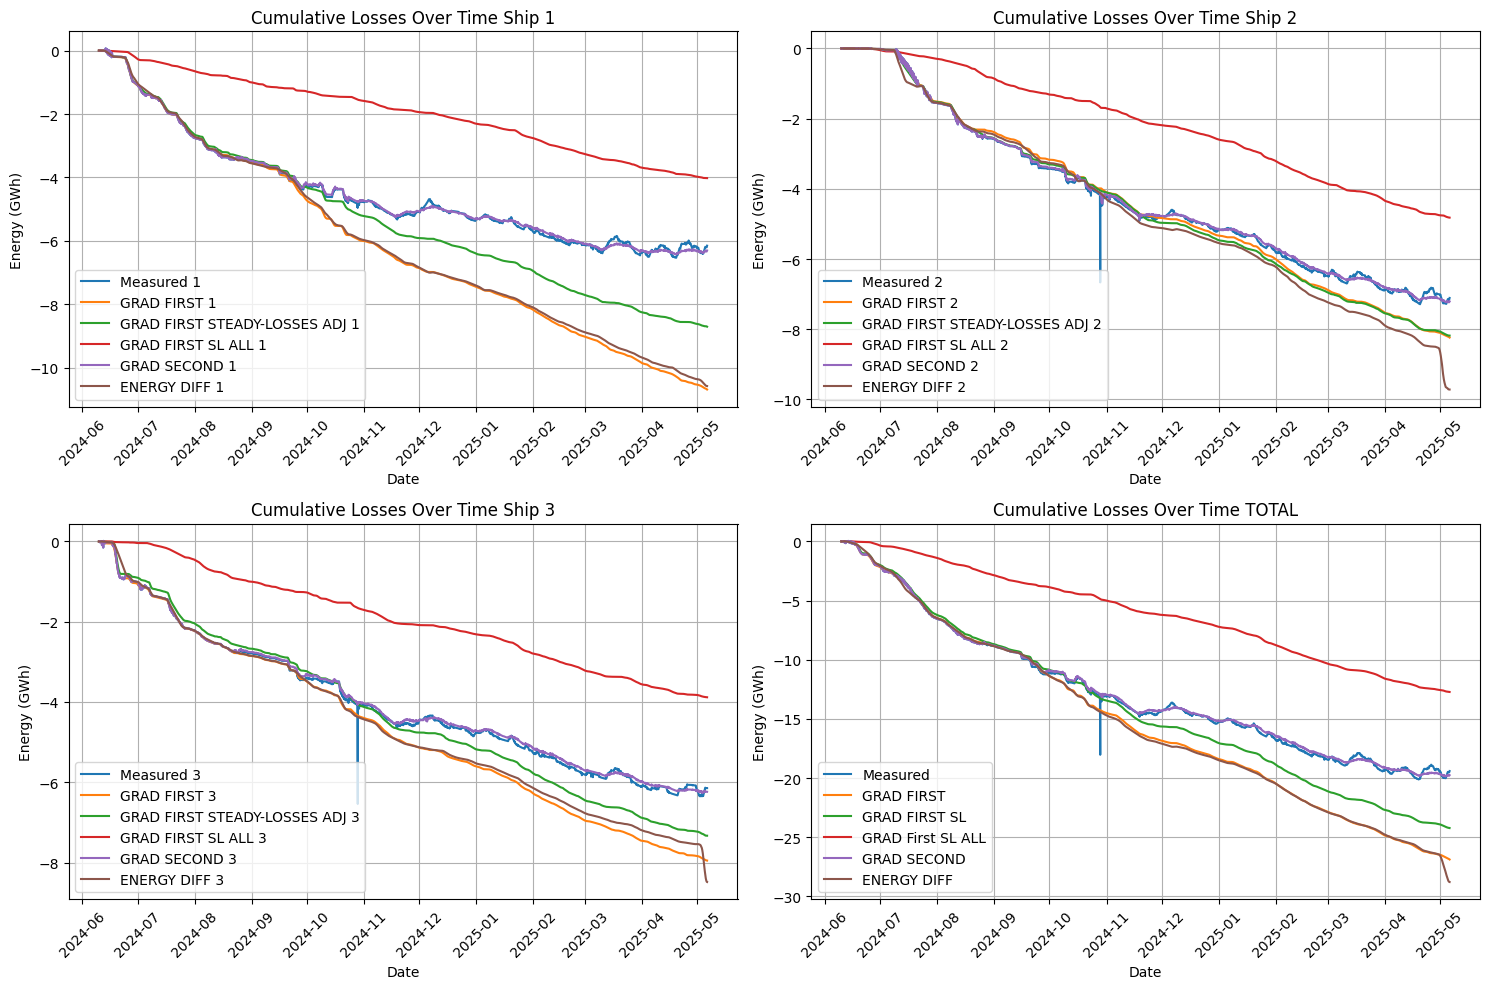

In [231]:
def GRADIENT_FIRST_STEADY_LOSSES(energy, time_vec, charge_meas, discharge_meas, df_power, adj=[1,1]):
    """Calculate through gradient first method. """

    # Power calculations 
    _, _, _, losses, steady_losses = calculate_power(energy, time_vec, adj[0] * charge_meas, adj[1] * discharge_meas)
   
    # Find the indicies of different stages
    find_charge, find_discharge, find_steady_losses = find_charge_discharge(df_power)

    # Calculate the mean loss around discharging
    gradient_first = calculate_mean_loss_during_discharging(losses, find_discharge, find_steady_losses)

    # First smoothing
    gradient_first = smooth_over_windows(find_charge, find_discharge, find_steady_losses, gradient_first, filter_size=25)

    # Final smoothing
    gradient_first = smooth_and_adjust_power(gradient_first, adj[1] * discharge_meas, threshold_factor=1, filter_size=25)

    # Reduce noice in the losses
    gradient_first = savgol_filter(gradient_first, window_length=23, polyorder=3)
   
    # Calculate the cumulative energy loss
    cum_energy_loss = gradient_first.cumsum()

    return cum_energy_loss, gradient_first

# Calculate the adjusted energy withoit the charge and discharge = losses over time
start = 1800
init = slice(0, start)
rest = slice(start, len(temp_time))

# Calculate the adjusted energy without the charge and discharge = losses over time
measured_energy1 = np.concatenate((energy_skepp1[init], df_power['Skepp 1 Energi [MWh]'].iloc[rest].values - (df_power['Skepp 1 Energi [MWh]'].iloc[start] - energy_skepp1[start])))
energy_loss_meas1 =  measured_energy1 - cum_charge_measured1 - cum_discharge_measured1 - energy_skepp1[0]
measured_energy2 = np.concatenate((energy_skepp2[init], df_power['Skepp 2 Energi [MWh]'].iloc[rest].values - (df_power['Skepp 2 Energi [MWh]'].iloc[start] - energy_skepp2[start])))
energy_loss_meas2 =  measured_energy2 - cum_charge_measured2_adjust - cum_discharge_measured2 - energy_skepp2[0]
measured_energy3 = np.concatenate((energy_skepp3[init], df_power['Skepp 3 Energi [MWh]'].iloc[rest].values - (df_power['Skepp 3 Energi [MWh]'].iloc[start] - energy_skepp3[start])))
energy_loss_meas3 =  measured_energy3 - cum_charge_measured3 - cum_discharge_measured3 - energy_skepp3[0]



############## Calcylate power through POWER_LOSS_CALC AND SMOOTH POWER (GRADIENT SECOND METHOD) #################

cum_energy_loss_grad_sec1, power_loss_vec_calc1, gradient_second1, power_loss_vec_calc_smoothest1 = GRADIENT_SECOND_METHOD(energy_skepp1, cum_charge_measured1, cum_discharge_measured1, discharge_measured1, temp_time_hours, adj=[1,1])
cum_energy_loss_grad_sec2, power_loss_vec_calc2, gradient_second2, power_loss_vec_calc_smoothest2 = GRADIENT_SECOND_METHOD(energy_skepp2, cum_charge_measured2_adjust, cum_discharge_measured2, discharge_measured2, temp_time_hours, adj=[1,1])
cum_energy_loss_grad_sec3, power_loss_vec_calc3, gradient_second3, power_loss_vec_calc_smoothest3 = GRADIENT_SECOND_METHOD(energy_skepp3, cum_charge_measured3, cum_discharge_measured3, discharge_measured3, temp_time_hours, adj=[1,1])

cum_energy_loss_grad_sec1_adj, power_loss_vec_calc1_adj, gradient_second1_adj, power_loss_vec_calc_smoothest1_adj = GRADIENT_SECOND_METHOD(energy_skepp1, cum_charge_measured1, cum_discharge_measured1, discharge_measured1, temp_time_hours, adj=[1.05, 0.89])
cum_energy_loss_grad_sec2_adj, power_loss_vec_calc2_adj, gradient_second2_adj, power_loss_vec_calc_smoothest2_adj = GRADIENT_SECOND_METHOD(energy_skepp2, cum_charge_measured2_adjust, cum_discharge_measured2, discharge_measured2, temp_time_hours, adj=[1.05, 0.94])
cum_energy_loss_grad_sec3_adj, power_loss_vec_calc3_adj, gradient_second3_adj, power_loss_vec_calc_smoothest3_adj = GRADIENT_SECOND_METHOD(energy_skepp3, cum_charge_measured3, cum_discharge_measured3, discharge_measured3, temp_time_hours, adj=[1.05, 0.91])


######################## calculated power function (GRADIENT FIRST METHOD) ################################

cum_energy_loss_grad_fir1, gradient_first1, steady_losses1 = GRADIENT_FIRST_METHOD(energy_skepp1, temp_time_hours, charge_measured1, discharge_measured1, df_power['Skepp 1 - Effekt [MW]'], adj=[1,1])
cum_energy_loss_grad_fir2, gradient_first2, steady_losses2 = GRADIENT_FIRST_METHOD(energy_skepp2, temp_time_hours, charge_measured2, discharge_measured2, df_power['Skepp 2 - Effekt [MW]'], adj=[1,1])
cum_energy_loss_grad_fir3, gradient_first3, steady_losses3 = GRADIENT_FIRST_METHOD(energy_skepp3, temp_time_hours, charge_measured3, discharge_measured3, df_power['Skepp 3 - Effekt [MW]'], adj=[1,1])

cum_energy_loss_grad_fir1_adj, gradient_first1_adj, steady_losses1_adj = GRADIENT_FIRST_METHOD(energy_skepp1, temp_time_hours, charge_measured1, discharge_measured1, df_power['Skepp 1 - Effekt [MW]'], adj = [0.98, 0.98])
cum_energy_loss_grad_fir2_adj, gradient_first2_adj, steady_losses2_adj = GRADIENT_FIRST_METHOD(energy_skepp2, temp_time_hours, charge_measured2, discharge_measured2, df_power['Skepp 2 - Effekt [MW]'], adj = [0.98, 0.98])
cum_energy_loss_grad_fir3_adj, gradient_first3_adj, steady_losses3_adj = GRADIENT_FIRST_METHOD(energy_skepp3, temp_time_hours, charge_measured3, discharge_measured3, df_power['Skepp 3 - Effekt [MW]'], adj = [0.98, 0.98])

######################## calculate power from energy diff function (ENERGY DIFF METHOD) ################################

cum_loss_ENERGY_DIFF1 = ENERGY_DIFF_METHOD(df_power['Skepp 1 - Effekt [MW]'], energy_skepp1, steady_losses1, cum_charge_measured1, cum_discharge_measured1)
cum_loss_ENERGY_DIFF2 = ENERGY_DIFF_METHOD(df_power['Skepp 2 - Effekt [MW]'], energy_skepp2, steady_losses2, cum_charge_measured2_adjust, cum_discharge_measured2)
cum_loss_ENERGY_DIFF3 = ENERGY_DIFF_METHOD(df_power['Skepp 3 - Effekt [MW]'], energy_skepp3, steady_losses3, cum_charge_measured3, cum_discharge_measured3)


####################### Calculate with (GRADIENT FIRST STEADY-LOSSES ADJ) ############################################
cum_loss_GRADIENT_FIRST_SL1, gradient_first_SL1 = GRADIENT_FIRST_STEADY_LOSSES(energy_skepp1, temp_time_hours, charge_measured1, discharge_measured1, df_power['Skepp 1 - Effekt [MW]'], adj=[1,1])
cum_loss_GRADIENT_FIRST_SL2, gradient_first_SL2 = GRADIENT_FIRST_STEADY_LOSSES(energy_skepp2, temp_time_hours, charge_measured2, discharge_measured2, df_power['Skepp 2 - Effekt [MW]'], adj=[1,1])
cum_loss_GRADIENT_FIRST_SL3, gradient_first_SL3 = GRADIENT_FIRST_STEADY_LOSSES(energy_skepp3, temp_time_hours, charge_measured3, discharge_measured3, df_power['Skepp 3 - Effekt [MW]'], adj=[1,1])


####################### Calculate with (GRADIENT FIRST STEADY-LOSSES ADJ) ############################################
cum_loss_GRADIENT_FIRST_SL1_ALL, gradient_first_SL1_ALL = GRADIENT_FIRST_STEADY_LOSSES_ALL(energy_skepp1, temp_time_hours, charge_measured1, discharge_measured1, df_power['Skepp 1 - Effekt [MW]'], adj=[1,1])
cum_loss_GRADIENT_FIRST_SL2_ALL, gradient_first_SL2_ALL = GRADIENT_FIRST_STEADY_LOSSES_ALL(energy_skepp2, temp_time_hours, charge_measured2, discharge_measured2, df_power['Skepp 2 - Effekt [MW]'], adj=[1,1])
cum_loss_GRADIENT_FIRST_SL3_ALL, gradient_first_SL3_ALL = GRADIENT_FIRST_STEADY_LOSSES_ALL(energy_skepp3, temp_time_hours, charge_measured3, discharge_measured3, df_power['Skepp 3 - Effekt [MW]'], adj=[1,1])

#######################################################################################################################

print(f'FVB predicted loss:                       {round(power_loss_predicted_cumsum_corrected[11*30*24],2)} GWh')
print(f'Total loss with ENERGY DIFF method:       {np.round(-(cum_loss_ENERGY_DIFF1 + cum_loss_ENERGY_DIFF2 + cum_loss_ENERGY_DIFF3).iloc[-1],2)} GWh')
print(f'Total loss with GRAD FIRST method:        {np.round(-(cum_energy_loss_grad_fir1 + cum_energy_loss_grad_fir2 + cum_energy_loss_grad_fir3)[-1]/1000,2)} GWh')
print(f'Total loss with GRAD FIRST SL method:     {np.round(-(cum_loss_GRADIENT_FIRST_SL1 + cum_loss_GRADIENT_FIRST_SL2 + cum_loss_GRADIENT_FIRST_SL3)[-1]/1000,2)} GWh')
print(f'Total loss with GRAD FIRST SL ALL method: {np.round(-(cum_loss_GRADIENT_FIRST_SL1_ALL + cum_loss_GRADIENT_FIRST_SL2_ALL + cum_loss_GRADIENT_FIRST_SL3_ALL)[-1]/1000,2)} GWh')

#######################################################################################################################

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot for Ship 1
axs[0, 0].plot(temp_time, energy_loss_meas1/1000, label='Measured 1')
axs[0, 0].plot(temp_time, cum_energy_loss_grad_fir1/1000, label='GRAD FIRST 1')
axs[0, 0].plot(temp_time, cum_loss_GRADIENT_FIRST_SL1/1000, label='GRAD FIRST STEADY-LOSSES ADJ 1')
axs[0, 0].plot(temp_time, cum_loss_GRADIENT_FIRST_SL1_ALL/1000, label='GRAD FIRST SL ALL 1')
axs[0, 0].plot(temp_time, cum_energy_loss_grad_sec1/1000, label='GRAD SECOND 1')
axs[0, 0].plot(temp_time, cum_loss_ENERGY_DIFF1, label='ENERGY DIFF 1')
#axs[0, 0].plot(temp_time, cum_energy_loss_grad_sec1_adj/1000, label='GRAD SECOND 1 adj')
#axs[0, 0].plot(temp_time, cum_energy_loss_grad_fir1_adj/1000, label='GRAD FIRST 1 adj')
axs[0, 0].set_title('Cumulative Losses Over Time Ship 1')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Energy (GWh)')
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 0].tick_params(axis='x', rotation=45)

# Plot for Ship 2
axs[0, 1].plot(temp_time, energy_loss_meas2/1000, label='Measured 2')
axs[0, 1].plot(temp_time, cum_energy_loss_grad_fir2/1000, label='GRAD FIRST 2')
axs[0, 1].plot(temp_time, cum_loss_GRADIENT_FIRST_SL2/1000, label='GRAD FIRST STEADY-LOSSES ADJ 2')
axs[0, 1].plot(temp_time, cum_loss_GRADIENT_FIRST_SL2_ALL/1000, label='GRAD FIRST SL ALL 2')
axs[0, 1].plot(temp_time, cum_energy_loss_grad_sec2/1000, label='GRAD SECOND 2')
axs[0, 1].plot(temp_time, cum_loss_ENERGY_DIFF2, label='ENERGY DIFF 2')
#axs[0, 1].plot(temp_time, cum_energy_loss_grad_fir2_adj/1000, label='GRAD FIRST 2 adj')
#axs[0, 1].plot(temp_time, cum_energy_loss_grad_sec2_adj/1000, label='GRAD SECOND 2 adj')
axs[0, 1].set_title('Cumulative Losses Over Time Ship 2')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Energy (GWh)')
axs[0, 1].legend()
axs[0, 1].grid(True)
axs[0, 1].tick_params(axis='x', rotation=45)

# Plot for Ship 3
axs[1, 0].plot(temp_time, energy_loss_meas3/1000, label='Measured 3')
axs[1, 0].plot(temp_time, cum_energy_loss_grad_fir3/1000, label='GRAD FIRST 3')
axs[1, 0].plot(temp_time, cum_loss_GRADIENT_FIRST_SL3/1000, label='GRAD FIRST STEADY-LOSSES ADJ 3')
axs[1, 0].plot(temp_time, cum_loss_GRADIENT_FIRST_SL3_ALL/1000, label='GRAD FIRST SL ALL 3')
axs[1, 0].plot(temp_time, cum_energy_loss_grad_sec3/1000, label='GRAD SECOND 3')
axs[1, 0].plot(temp_time, cum_loss_ENERGY_DIFF3, label='ENERGY DIFF 3')
#axs[1, 0].plot(temp_time, cum_energy_loss_grad_fir3_adj/1000, label='GRAD FIRST 3 adj')
#axs[1, 0].plot(temp_time, cum_energy_loss_grad_sec3_adj/1000, label='GRAD SECOND 3 adj')
axs[1, 0].set_title('Cumulative Losses Over Time Ship 3')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Energy (GWh)')
axs[1, 0].legend()
axs[1, 0].grid(True)
axs[1, 0].tick_params(axis='x', rotation=45)

# Plot for Total Loss
axs[1, 1].plot(temp_time, (energy_loss_meas1 + energy_loss_meas2 + energy_loss_meas3)/1000, label='Measured')
axs[1, 1].plot(temp_time, (cum_energy_loss_grad_fir1 + cum_energy_loss_grad_fir2 + cum_energy_loss_grad_fir3)/1000, label='GRAD FIRST')
axs[1, 1].plot(temp_time, (cum_loss_GRADIENT_FIRST_SL1 + cum_loss_GRADIENT_FIRST_SL2 + cum_loss_GRADIENT_FIRST_SL3)/1000, label='GRAD FIRST SL')
axs[1, 1].plot(temp_time, (cum_loss_GRADIENT_FIRST_SL1_ALL + cum_loss_GRADIENT_FIRST_SL2_ALL + cum_loss_GRADIENT_FIRST_SL3_ALL)/1000, label='GRAD First SL ALL')
axs[1, 1].plot(temp_time, (cum_energy_loss_grad_sec1 + cum_energy_loss_grad_sec2 + cum_energy_loss_grad_sec3)/1000, label='GRAD SECOND')
axs[1, 1].plot(temp_time, (cum_loss_ENERGY_DIFF1 + cum_loss_ENERGY_DIFF2 + cum_loss_ENERGY_DIFF3), label='ENERGY DIFF')
axs[1, 1].set_title('Cumulative Losses Over Time TOTAL')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Energy (GWh)')
axs[1, 1].legend()
axs[1, 1].grid(True)
axs[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

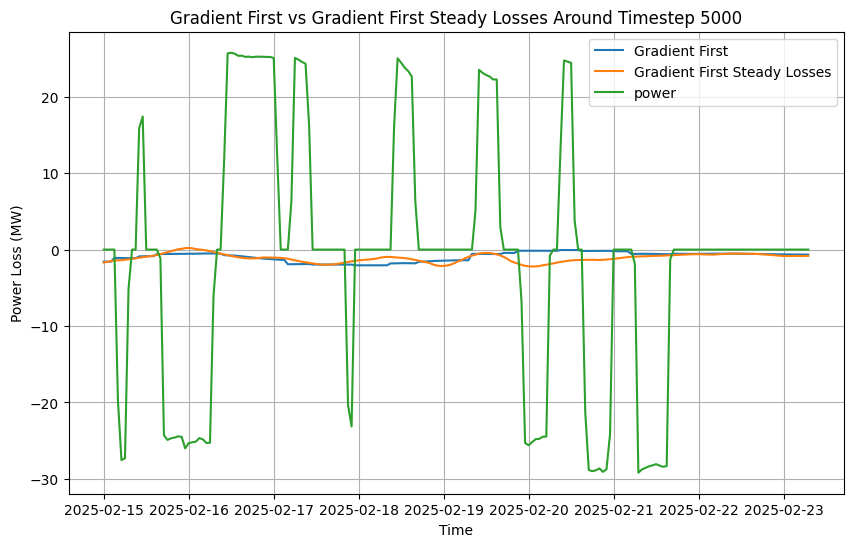

In [232]:
# Define the range around timestep 5000
when = slice(6000, 6200)

# Plot grad_first and grad_first_sl
plt.figure(figsize=(10, 6))
plt.plot(temp_time[when], gradient_first2[when], label='Gradient First')
plt.plot(temp_time[when], gradient_first_SL2[when], label='Gradient First Steady Losses')
plt.plot(temp_time[when], df_power['Skepp 2 - Effekt [MW]'].iloc[when], label='power', )
plt.xlabel('Time')
plt.ylabel('Power Loss (MW)')
plt.title('Gradient First vs Gradient First Steady Losses Around Timestep 5000')
plt.legend()
plt.grid(True)
plt.show()

Fitted parameters: [ 4.3583966  -0.74263591  0.71070289]
RMSE: 0.12146414424320419
R-squared: 0.9862090355075808


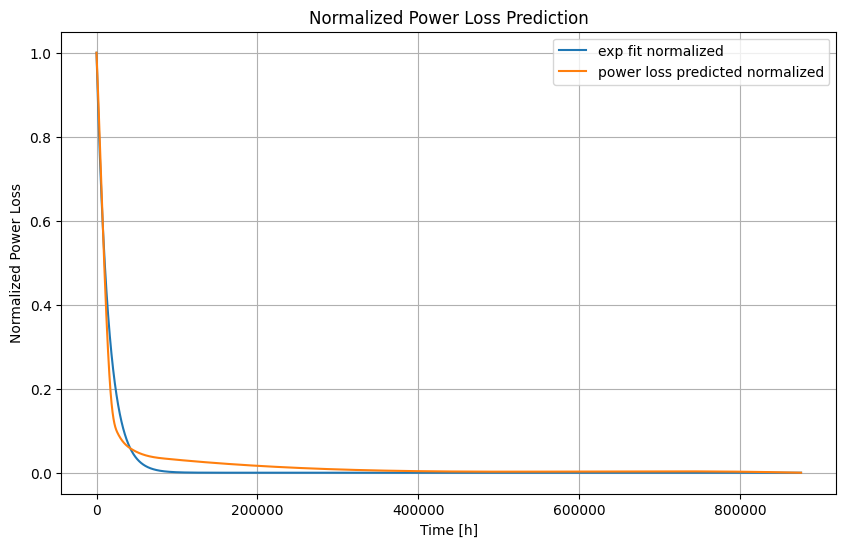

In [233]:
# Plotting the power loss prediction exponential curve fit

def func(x, a, b, c):
    return a * np.exp(b * x) + c

# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = func(xData, *parameterTuple)
    return np.sum((yData - val) ** 2.0)

# generate initial parameter values
def generate_Initial_Parameters():
    """Initial parameter generation. """
    parameterBounds = []
    parameterBounds.append([0.0, 100.0]) # search bounds for a
    parameterBounds.append([-10.0, 0.0]) # search bounds for b
    parameterBounds.append([0.0, 10.0]) # search bounds for c

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

def exponential_model(xData,yData):
    """Logistical model. """
    # by default, differential_evolution completes by calling curve_fit() using parameter bounds
    geneticParameters = generate_Initial_Parameters()

    # now call curve_fit without passing bounds from the genetic algorithm,
    # just in case the best fit parameters are aoutside those bounds
    fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)
    print('Fitted parameters:', fittedParameters)

    modelPredictions = func(xData, *fittedParameters) 

    absError = modelPredictions - yData

    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(yData))
    
    # create data for the fitted equation plot
    hourly_data_points = 100*365*24
    xModel = np.linspace(min(xData), max(xData),hourly_data_points)
    yModel = func(xModel, *fittedParameters)

    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)

    return yModel, xModel, fittedParameters


# Read the operational data from a CSV file
data_power = pd.read_csv('C:/Users/extaxha/Documents/project_data/estimated_power_loss.csv')
starting_value = pd.DataFrame({'year': [0], 'loss': [5]})
data_power = pd.concat([starting_value, data_power], ignore_index=True)

# Calculate the hours from the years
hours = data_power['year']
heat_loss = data_power['loss']

contineous_heat_loss = 0.65 # 6.4% of 100GWh from report

# Calculate the fitted logarithmic curve using the filtered data
xData = hours
yData = heat_loss
y_fit, x_fit, exp_param = exponential_model(xData, yData)


# Known exponential parameters (yearly)
a_exp_yearly = exp_param[0]
b_exp_yearly = exp_param[1]
c_exp_yearly = exp_param[2]

# Convert b from yearly to hourly
b_exp_hourly = b_exp_yearly / 8760
exp_param_hourly = [a_exp_yearly, b_exp_hourly*0.8, c_exp_yearly] 

###################################
exp_time = np.linspace(0, len(power_loss_predicted)-1, len(power_loss_predicted))
paramsexp, covarianceexp = curve_fit(func, exp_time, power_loss_predicted-power_loss_predicted[-1])

# Normalize the exponential function between 1 and 0. add value for boost
exp = func(exp_time, *exp_param_hourly)
exp_normalized = (exp - np.min(exp)) / (np.max(exp) - np.min(exp))
power_loss_predicted_normalized = 0.0 + (power_loss_predicted - np.min(power_loss_predicted)) / (np.max(power_loss_predicted) - np.min(power_loss_predicted))

plt.figure(figsize=(10, 6))
plt.plot(exp_time, exp_normalized, label='exp fit normalized')
plt.plot(exp_time, power_loss_predicted_normalized, label='power loss predicted normalized')
plt.xlabel('Time [h]')
plt.ylabel('Normalized Power Loss')
plt.title('Normalized Power Loss Prediction')
plt.legend()
plt.grid()
plt.show()


# y_fit, x_fit = logistical_model(xData, yData)
# plt.figure(figsize=(10, 6))
# plt.plot(x_fit, y_fit, label='Logistical Fit', color='red')
# #plt.plot(exp_time, exp, label='Exponential Fit', color='blue')

In [328]:
# Calculate the fitted power loss using the exponential model + linear fit
from dcor import distance_correlation
from sklearn.metrics import r2_score

def linear_model(energy, k):
    """Linear model for power loss calculation. m is the total calculated continuation loss divided by three ships."""
    m = fvb_cont_loss = FVB_continuous_loss_formula(95, 45)/3
    return k * energy #- m

def power_loss_fit_smooth(energy, power_loss,power_loss_predicted_normalized):
    """Fit the power loss to the energy with smoothing through characteristic time."""

    # Calculate the smoothed loss using uniform filter
    smoothed_loss = np.copy(power_loss)

    # Apply a uniform filter to smooth the data
    #smoothed_loss = uniform_filter(smoothed_loss, 120)

    ##################### Add characteristic time estimation smoothing
    tau_est = estimate_characteristic_time(smoothed_loss, 1)

    smoothed_loss = gaussian_filter1d(smoothed_loss, sigma=tau_est)

    tau_est = estimate_characteristic_time(energy, 1)/5
    tau_est = 70

    smoothed_energy = energy #gaussian_filter1d(energy, sigma=tau_est)
    #####################

    # improve the fit by removing the first part of the data
    dates = slice(4000,len(smoothed_loss)) 

    # apply curve fit
    params, covariance = curve_fit(linear_model, smoothed_energy[dates], smoothed_loss[dates])

    # Calculate the fitted loss using the fitted parameters
    k1 = params[0] * (power_loss_predicted_normalized[0:len(energy)])

    # calcualte the linear fit
    m = FVB_continuous_loss_formula(95, 45)/3
    fitted_loss = linear_model(smoothed_energy, k1[:]) - m
    fitted_loss = gaussian_filter1d(fitted_loss, tau_est/3) 

    # Compute Pearson and Spearman correlations for each ship
    pearson_corr, _ = pearsonr(smoothed_energy[dates]*power_loss_predicted_normalized[dates], smoothed_loss[dates])
    spearman_corr, _ = spearmanr(smoothed_energy[dates]*power_loss_predicted_normalized[dates], smoothed_loss[dates])
    print(f'Pearson correlation:  {round(pearson_corr, 2)}')
    print(f'Spearman correlatio:  {round(spearman_corr, 2)}')

    loss_diff = np.sum(smoothed_loss[dates] - fitted_loss[dates])
    print(f'Loss difference:      {np.round(np.mean(loss_diff), 2)} MW') 

    return fitted_loss, smoothed_loss, pearson_corr, spearman_corr, loss_diff

def power_loss_fit_ENERGY_DIFF(cum_loss_energy_diff, energy, temp_time_hours, charge_measured, discharge_measured, df_power, power_loss_predicted_normalized, filter_size=25, threshold_factor=1):
    """
    Perform energy difference method with all steps included.
    """
    when = slice(0, len(cum_loss_energy_diff)-29)
    power_loss, _, _, _, _ = calculate_power(cum_loss_energy_diff[when] * 1000, temp_time_hours[when], charge_measured[when], discharge_measured[when])

    # Find the indices of different stages
    find_charge, find_discharge, find_steady_losses = find_charge_discharge(df_power.iloc[when])

    # First smoothing
    power_loss = smooth_over_windows(find_charge, find_discharge, find_steady_losses, power_loss, filter_size=filter_size)

    # Final smoothing
    power_loss = smooth_and_adjust_power(power_loss, discharge_measured[when], threshold_factor=threshold_factor, filter_size=15)

    # Fit the power loss
    fitted_loss, smoothest, pearson_corr, spearman_corr, loss_diff = power_loss_fit_smooth(energy[when], power_loss, power_loss_predicted_normalized)

    return power_loss, fitted_loss, smoothest, pearson_corr, spearman_corr, loss_diff

print('Gradient First SL method:')
fitted_loss_SL1, gradient_first_SL1_smoothest, pearson_corr, spearman_corr, loss_diff = power_loss_fit_smooth(energy_skepp1, gradient_first_SL1 ,power_loss_predicted_normalized)
fitted_loss_SL2, gradient_first_SL2_smoothest, pearson_corr, spearman_corr, loss_diff = power_loss_fit_smooth(energy_skepp2, gradient_first_SL2 ,power_loss_predicted_normalized)
fitted_loss_SL3, gradient_first_SL3_smoothest, pearson_corr, spearman_corr, loss_diff = power_loss_fit_smooth(energy_skepp3, gradient_first_SL3 ,power_loss_predicted_normalized)
print('')
print('Gradient First method:')
fitted_loss_GF1, gradient_first1_smoothest, pearson_corr, spearman_corr, loss_diff = power_loss_fit_smooth(energy_skepp1, gradient_first1 ,power_loss_predicted_normalized)
fitted_loss_GF2, gradient_first2_smoothest, pearson_corr, spearman_corr, loss_diff = power_loss_fit_smooth(energy_skepp2, gradient_first2 ,power_loss_predicted_normalized)
fitted_loss_GF3, gradient_first3_smoothest, pearson_corr, spearman_corr, loss_diff = power_loss_fit_smooth(energy_skepp3, gradient_first3 ,power_loss_predicted_normalized)
print('')
print('Energy diff method:')
losses_ED1, fitted_loss_ED1, ED1_smoothest, pearson_corr, spearman_corr, loss_diff = power_loss_fit_ENERGY_DIFF(cum_loss_ENERGY_DIFF1, energy_skepp1, temp_time_hours, charge_measured1, discharge_measured1, df_power['Skepp 1 - Effekt [MW]'],power_loss_predicted_normalized)
losses_ED2, fitted_loss_ED2, ED2_smoothest, pearson_corr, spearman_corr, loss_diff = power_loss_fit_ENERGY_DIFF(cum_loss_ENERGY_DIFF2, energy_skepp2, temp_time_hours, charge_measured2, discharge_measured2, df_power['Skepp 2 - Effekt [MW]'],power_loss_predicted_normalized)
losses_ED3, fitted_loss_ED3, ED3_smoothest, pearson_corr, spearman_corr, loss_diff = power_loss_fit_ENERGY_DIFF(cum_loss_ENERGY_DIFF3, energy_skepp3, temp_time_hours, charge_measured3, discharge_measured3, df_power['Skepp 3 - Effekt [MW]'],power_loss_predicted_normalized)


# Plotting the results
when = slice(0, len(temp_time)-29)

fig, axs = plt.subplots(3, 3, figsize=(16, 12))  # Slightly smaller and tighter

methods = ['GF', 'GF SL', 'ED']
tanks = ['Ship 1', 'Ship 2', 'Ship 3']

# Column titles
for j, tank in enumerate(tanks):
    axs[0, j].set_title(tank, fontsize=11)

# Y-axis labels (vertical)
for i, method in enumerate(methods):
    axs[i, 0].set_ylabel(f'{method}\nPower Loss (MW)', fontsize=10)

# Plotting data
plot_data = [
    (gradient_first1, gradient_first1_smoothest, fitted_loss_GF1),
    (gradient_first2, gradient_first2_smoothest, fitted_loss_GF2),
    (gradient_first3, gradient_first3_smoothest, fitted_loss_GF3),
    (gradient_first_SL1, gradient_first_SL1_smoothest, fitted_loss_SL1),
    (gradient_first_SL2, gradient_first_SL2_smoothest, fitted_loss_SL2),
    (gradient_first_SL3, gradient_first_SL3_smoothest, fitted_loss_SL3),
    (losses_ED1[when], ED1_smoothest, fitted_loss_ED1),
    (losses_ED2[when], ED2_smoothest, fitted_loss_ED2),
    (losses_ED3[when], ED3_smoothest, fitted_loss_ED3),
]

for idx, ax in enumerate(axs.flat):
    row = idx // 3
    col = idx % 3
    raw, smooth, fitted = plot_data[idx]
    time = temp_time[when] if row == 2 else temp_time

    ax.plot(time, raw, color='grey', linewidth=0.3, label='Raw')
    ax.plot(time, smooth, label='Smoothed')
    ax.plot(time, fitted, label='Fitted', linewidth=2)
    ax.axvline(x=temp_time[4000], color='green', linestyle='--')
    ax.plot(daily_time[:len(df_power):30*24], -power_loss_predicted[:len(df_power):30*24]/3, 'o-', color='red', label='Predicted')
    ax.set_ylim(-4, 0)
    ax.grid(True, which='both', linestyle='--', linewidth=0.4)
    
    # Tick labels
    if row != 2:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Time', fontsize=9)
    if col != 0:
        ax.set_yticklabels([])
    else:
        # Remove the last number on the y-axis
        yticks = ax.get_yticks()
        ax.set_yticks(yticks[1:])
        ax.set_yticklabels(yticks[1:], fontsize=8)

    ax.tick_params(axis='x', rotation=45, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.legend(fontsize=7, loc='lower right')
  

plt.tight_layout(pad=1.2, h_pad=-1, w_pad=-1)
plt.suptitle('      Power Loss Calculations', fontsize=14, y=1.02)
plt.savefig('losses_power_tight_all_legends.png', dpi=300, bbox_inches='tight')
plt.show()


Gradient First SL method:
Pearson correlation:  -0.68
Spearman correlatio:  -0.69
Loss difference:      21.72 MW
Pearson correlation:  -0.73
Spearman correlatio:  -0.73
Loss difference:      -114.21 MW
Pearson correlation:  -0.65
Spearman correlatio:  -0.64
Loss difference:      106.17 MW

Gradient First method:
Pearson correlation:  -0.67
Spearman correlatio:  -0.67
Loss difference:      -410.06 MW
Pearson correlation:  -0.67
Spearman correlatio:  -0.67
Loss difference:      -154.31 MW
Pearson correlation:  -0.58
Spearman correlatio:  -0.56
Loss difference:      -50.83 MW

Energy diff method:
Pearson correlation:  -0.49
Spearman correlatio:  -0.5
Loss difference:      -444.42 MW
Pearson correlation:  -0.19
Spearman correlatio:  -0.61
Loss difference:      -523.0 MW
Pearson correlation:  -0.12
Spearman correlatio:  -0.61
Loss difference:      -115.87 MW


In [269]:
def GRADIENT_FIRST_STEADY_LOSSES_ALL(energy, time_vec, charge_meas, discharge_meas, df_power, adj=[1,1]):
    """Calculate through gradient first method. """

    # Power calculations 
    _, _, _, _, steady_losses = calculate_power(energy, time_vec, adj[0] * charge_meas, adj[1] * discharge_meas)
   
    # Find the indicies of different stages
    find_charge, find_discharge, find_steady_losses = find_charge_discharge(df_power)

    # Calculate the mean loss around discharging
    gradient_first = calculate_mean_loss_during_discharging(steady_losses, find_discharge, find_steady_losses)

    # Calculate the mean loss around charging
    gradient_first = calculate_mean_loss_during_charging(gradient_first, find_charge, find_steady_losses)

    # First smoothing
    gradient_first = smooth_over_windows(find_charge, find_discharge, find_steady_losses, gradient_first, filter_size=25)

    # Final smoothing
    gradient_first = smooth_and_adjust_power(gradient_first, adj[1] * discharge_meas, threshold_factor=1, filter_size=25)

    # Reduce noice in the losses
    gradient_first = savgol_filter(gradient_first , window_length=72, polyorder=3)

    # Calculate the cumulative energy loss
    cum_energy_loss = gradient_first.cumsum()

    return cum_energy_loss, gradient_first


# Visualisation of the difference ways to calculate losses.
power, calc_charge, calc_discharge, losses, steady_losses = calculate_power(energy_skepp1, temp_time_hours, charge_measured1, discharge_measured1)

fig, axs = plt.subplots(3, 1, figsize=(15, 12))

# First subplot
when = slice(2450, 2600)
axs[0].plot(temp_time[when], power[when], linewidth = 2, label='Calculated Power')
axs[0].plot(temp_time[when], df_power['Skepp 1 - Effekt [MW]'].iloc[when], linewidth = 2, label='District Power')
axs[0].plot(temp_time[when], np.gradient(cum_energy_loss_grad_sec1)[when], linestyle ='--', label='Gradient Second Like')
axs[0].plot(temp_time[when], charge_storage1[when]+discharge_storage1[when], linewidth = 2, label='Storage Power')
#axs[0].plot(temp_time[when], gradient_first1[when], linestyle ='--', label = 'Gradient first')
axs[0].plot(temp_time[when], losses[when], linestyle ='--', label = 'Gradient First Like')
axs[0].set_title('Early Example: Sep 24')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Power (MW)')
axs[0].legend()
axs[0].grid(True)

# Second subplot
when = slice(4800, 5100)
axs[1].plot(temp_time[when], power[when], linewidth = 2, label='Calculated Power')
axs[1].plot(temp_time[when], df_power['Skepp 1 - Effekt [MW]'].iloc[when], linewidth = 2, label='District Power')
axs[1].plot(temp_time[when], np.gradient(cum_energy_loss_grad_sec1)[when], linestyle ='--', label='Gradient Second Like')
axs[1].plot(temp_time[when], charge_storage1[when]+discharge_storage1[when], linewidth = 2, label='Storage Power')
#axs[1].plot(temp_time[when], gradient_first1[when], linestyle ='--', label = 'Gradient first')
axs[1].plot(temp_time[when], losses[when], linestyle ='--', label = 'Gradient First Like')
axs[1].set_title('Later Example: Jan 25')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Power (MW)')
axs[1].legend()
axs[1].grid(True)

when = slice(7600, 7800)
axs[2].plot(temp_time[when], power[when], linewidth = 2, label='Calculated Power')
axs[2].plot(temp_time[when], df_power['Skepp 1 - Effekt [MW]'].iloc[when], linewidth = 2, label='District Power')
axs[2].plot(temp_time[when], np.gradient(cum_energy_loss_grad_sec1)[when], linestyle ='--', label='Gradient Second Like')
axs[2].plot(temp_time[when], charge_storage1[when]+discharge_storage1[when], linewidth = 2, label='Storage Power')
#axs[0].plot(temp_time[when], gradient_first1[when], linestyle ='--', label = 'Gradient first')
axs[2].plot(temp_time[when], losses[when], linestyle ='--', label = 'Gradient First Like')
axs[2].set_title('Early Example: April 25')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Power (MW)')
axs[2].legend()
axs[2].grid(True)
plt.tight_layout()
plt.suptitle('Example of Loss Calculation Styles', fontsize=16, y=1.02)
plt.show()




Different calculation styles. In the last plot, suddenly the district heat exchange power is smaller than the storage power... this is not good. Hence the other power. Also the other power, the storage heat exhange power, is flawed at some points. 
IDEA: change the odd flwaed data to the district side*ratio.

In [248]:
# Sensitivity analysis for different adj values
def sensitivity_analysis(adj_values, energy_skepp, cum_charge_measured, cum_discharge_measured, charge_measured, discharge_measured, temp_time_hours, df_power, steady_losses):
    """Perform sensitivity analysis for different adj values."""

    baseline_output_sec, _ , _ , _ = GRADIENT_SECOND_METHOD(energy_skepp, cum_charge_measured, cum_discharge_measured, discharge_measured, temp_time_hours, adj=[1,1])
    baseline_output_sec = baseline_output_sec/1000

    baseline_output_fir, _ , _ = GRADIENT_FIRST_METHOD(energy_skepp, temp_time_hours, charge_measured, discharge_measured, df_power, adj=[1,1])
    baseline_output_fir = baseline_output_fir/1000

    baseline_output_ED = ENERGY_DIFF_METHOD(df_power, energy_skepp, steady_losses, cum_charge_measured, cum_discharge_measured, adj=[1,1])

    baseline_output_SL = GRADIENT_FIRST_STEADY_LOSSES(energy_skepp, temp_time_hours, charge_measured, discharge_measured, df_power,adj=[1,1])
    baseline_output_SL = baseline_output_SL[0]/1000

    results_sec = []
    results_fir = []
    results_ED = []
    results_SL = []

        # Loop through each adj value for GRADIENT_FIRST_METHOD1
    for adj in adj_values:
        output_fir, _ , _ = GRADIENT_FIRST_METHOD(energy_skepp, temp_time_hours, charge_measured, discharge_measured, df_power, adj=[1*adj,1*adj])
        output_fir = output_fir/1000
        delta_fir = output_fir - baseline_output_fir
        results_fir.append((adj, output_fir, delta_fir))

        # Loop through each adj value for ENERGY_DIFF_METHOD1
    for adj in adj_values:
        output_ED = ENERGY_DIFF_METHOD(df_power, energy_skepp, steady_losses, cum_charge_measured, cum_discharge_measured, adj=[1*adj,1*adj])
        delta_ED = output_ED - baseline_output_ED
        results_ED.append((adj, output_ED, delta_ED))

        # Loop through each adj value for GRADIENT_FIRST_STEADY_LOSSES1
    for adj in adj_values:
        output_SL = GRADIENT_FIRST_STEADY_LOSSES(energy_skepp, temp_time_hours, charge_measured, discharge_measured, df_power, adj=[1*adj,1*adj])
        output_SL = output_SL[0]/1000
        delta_SL = output_SL - baseline_output_SL
        results_SL.append((adj, output_SL, delta_SL))
        
        # Loop through each adj value
    for adj in adj_values:
        output_sec= GRADIENT_SECOND_METHOD(energy_skepp, cum_charge_measured, cum_discharge_measured, discharge_measured, temp_time_hours,adj=[1*adj,1*adj])
        output_sec = output_sec[0]/1000
        delta_sec = output_sec - baseline_output_sec
        results_sec.append((adj, output_sec, delta_sec))


    # Extract results for plotting
    adj_vals_fir = [r[0] for r in results_fir]
    outputs_fir = [r[1] for r in results_fir]
    delta_fir = [r[2] for r in results_fir]

    adj_vals_ED = [r[0] for r in results_ED]
    outputs_ED = [r[1] for r in results_ED]
    delta_ED = [r[2] for r in results_ED]

    adj_vals_SL = [r[0] for r in results_SL]
    outputs_SL = [r[1] for r in results_SL]
    delta_SL = [r[2] for r in results_SL]

    # Extract results for plotting
    adj_vals_sec = [r[0] for r in results_sec]
    outputs_sec = [r[1] for r in results_sec]
    delta_sec = [r[2] for r in results_sec]

    ratio_fir = (output_fir[-1] - baseline_output_fir[-1]) / baseline_output_fir[-1] / (adj_values[-1]-1)
    

    ratio_sec = (output_sec.iloc[-1] - baseline_output_sec.iloc[-1]) / baseline_output_sec.iloc[-1]  / (adj_values[-1]-1)
    ratio_ED = (output_ED.iloc[-1] - baseline_output_ED.iloc[-1])  / baseline_output_ED.iloc[-1] / (adj_values[-1]-1)
    ratio_SL = (output_SL[-1] - baseline_output_SL[-1])  / baseline_output_SL[-1] / (adj_values[-1]-1)

    print(f"Uutput percentage change per percentage change in the measured charge and discharge:")
    print(f"Gradient First Method:               {round(ratio_fir,2)} %")
    print(f"Gradient Second Method:              {round(ratio_sec,2)} %")
    print(f"Energy Difference Method:            {round(ratio_ED,2)} %")
    print(f"Gradient First Steady Losses Method: {round(ratio_SL,2)} %")


    # Create a 2x2 subplot for the results
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot the results for GRADIENT_FIRST_METHOD1
    for i in range(len(adj_vals_fir)):
        axs[0, 0].plot(temp_time, outputs_fir[i], label=f'adj = {adj_vals_fir[i]}')
    axs[0, 0].plot(temp_time, baseline_output_fir, label='Baseline', color='black', linewidth=2)
    axs[0, 0].set_ylabel("Energy Loss (GWh)")
    axs[0, 0].set_title(f"Gradient First Method (1:{ratio_fir:.2f} %)")
    axs[0, 0].grid(True)
    axs[0, 0].tick_params(axis='x', rotation=45)
    axs[0, 0].legend()

    # Plot the results for ENERGY_DIFF_METHOD1
    for i in range(len(adj_vals_ED)):
        axs[0, 1].plot(temp_time, outputs_ED[i], label=f'adj = {adj_vals_ED[i]}')
    axs[0, 1].plot(temp_time, baseline_output_ED, label='Baseline', color='black', linewidth=2)
    axs[0, 1].set_title(f"Energy Difference  Method (1:{ratio_ED:.2f} %)")
    axs[0, 1].grid(True)
    axs[0, 1].tick_params(axis='x', rotation=45)
    axs[0, 1].legend()

    # Plot the results for GRADIENT_FIRST_STEADY_LOSSES1
    for i in range(len(adj_vals_SL)):
        axs[1, 0].plot(temp_time, outputs_SL[i], label=f'adj = {adj_vals_SL[i]}')
    axs[1, 0].plot(temp_time, baseline_output_SL, label='Baseline', color='black', linewidth=2)
    axs[1, 0].set_xlabel("Time")
    axs[1, 0].set_ylabel("Energy Loss (GWh)")
    axs[1, 0].set_title(f"Gradient First Steady Losses Method (1:{ratio_SL:.2f} %)")
    axs[1, 0].grid(True)
    axs[1, 0].tick_params(axis='x', rotation=45)
    axs[1, 0].legend()

    # Plot the results for GRADIENT_SECOND_METHOD1
    for i in range(len(adj_vals_sec)):
        axs[1, 1].plot(temp_time, outputs_sec[i], label=f'adj = {adj_vals_sec[i]}')
    axs[1, 1].plot(temp_time, baseline_output_sec, label='Baseline', color='black', linewidth=2)
    axs[1, 1].set_xlabel("Time")
    axs[1, 1].set_title(f"Gradient Second Method (1:{ratio_sec:.2f} %)")
    axs[1, 1].grid(True)
    axs[1, 1].tick_params(axis='x', rotation=45)
    axs[1, 1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.suptitle('Sensitivity Analysis', fontsize=16, y=1.02)
    #plt.savefig('sensitivity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    return output_sec, output_fir, output_ED, output_SL

adj_values = [0.8, 0.85, 0.9, 0.95, 1.05, 1.1, 1.15, 1.2]

sa_sec, sa_fir, sa_ED, sa_SL = sensitivity_analysis(adj_values, energy_skepp1+energy_skepp2+energy_skepp3, cum_charge_measured1+cum_charge_measured2+cum_charge_measured3, cum_discharge_measured1+cum_discharge_measured2+cum_discharge_measured3, charge_measured1+charge_measured2+charge_measured3, discharge_measured1+discharge_measured2+discharge_measured3, temp_time_hours, df_power['Skepp 1 - Effekt [MW]']+df_power['Skepp 2 - Effekt [MW]']+df_power['Skepp 3 - Effekt [MW]'], steady_losses1+steady_losses2+steady_losses3)


Uutput percentage change per percentage change in the measured charge and discharge:
Gradient First Method:               6.97 %
Gradient Second Method:              2.02 %
Energy Difference Method:            -0.0 %
Gradient First Steady Losses Method: 4.42 %


In [348]:
# Calculate the power of the ship
def calculate_power1(energy, time, measured_charge, measured_discharge, threshold=10):           # ONE CAN CHANGE THIS, FOR DISCHARGE!
    """Calculate the power of a ship thrugh by using the gradient. A threshold is used. Does not work in the intial warming up. """
    # calculate the power through numeric gradient
    power = np.gradient(energy, time)
    
    # allocate memory for the charge, discharge and losses
    calc_charge = np.zeros_like(power)
    calc_discharge = np.zeros_like(power)
    losses = np.zeros_like(power)

    # calculate the charge, discharge and losses
    for i in range(1, len(power)):
        if measured_charge.iloc[i] > 0:
            # charge, for current and previous timepoint
            calc_charge[i] = power[i]
            if power[i-1] > threshold/2:
                calc_charge[i-1] = power[i-1]
        elif  measured_discharge.iloc[i] < 0: # power[i] < -threshold or
            # discharge, for current and previous timepoint
            calc_discharge[i] = power[i]
            if power[i-1] < -threshold/2:
                calc_discharge[i-1] = power[i-1]
        else: #power[i] < 0 and power[i] > -threshold/2:
            losses[i] = power[i]
  
    steady_losses = np.copy(losses)
    # calculate the losses from charge and discharge
    losses += (calc_charge - measured_charge)
    losses += (calc_discharge - measured_discharge) # ändrat till rätt
   
   
    return power, calc_charge, calc_discharge, losses, steady_losses # add to check of measuread and calculated power is at the same time instant?

def smooth_and_adjust_power1(data,discharge_meas, threshold_factor=1, filter_size=5):
    """
    Smooth outliers in the data using a moving average filter and adjust positive peaks with negative ones.

    Parameters:
    data (array-like): The input data array.
    threshold_factor (float): The factor to determine the threshold for outliers.
    filter_size (int): The size of the moving average filter.

    Returns:
    array-like: The smoothed data with adjusted power values.
    """

    ################ ADJUST FOR POSITIVE LOSSES ################
    data_copy = np.copy(data)
    discharge_meas_copy = np.copy(discharge_meas)

    # Find the positive power values
    pos_power = np.where(data_copy > 0, data_copy, 0)

    # Find the values and indices where pos_power also corresponds to the discharging in discharge_meas
    discharge_indices = np.where(discharge_meas_copy < 0)[0]
    pos_power_indices = np.where(pos_power > 0)[0]

    # Find common indices
    common_indices = np.intersect1d(discharge_indices, pos_power_indices)

    # Create a new vector with the same indices, initialized with zeros
    new_vector = np.zeros_like(pos_power)

    # Save the common values at the common indices in the new vector
    new_vector[common_indices] = pos_power[common_indices]
    # Adjust the positive losses

    data_copy += - 2* new_vector


    ##########################################################
    # Define a threshold to identify outliers
    threshold = threshold_factor * np.std(data_copy)

    # Identify outliers
    mean = np.mean(data_copy)
    outliers = np.abs(data_copy - mean) > threshold
    smoothed_data = np.copy(data_copy)
    length = len(data_copy)

    for i in range(length):
            if smoothed_data[i] > 0:
                # Look for a negative peak within the window before and after the current index
                for j in range(max(0, i - filter_size), min(i + filter_size, length)):
                    if smoothed_data[j] < 0:
                        # Cancel out the peaks
                        adjustment = min(smoothed_data[i], abs(smoothed_data[j]))
                        smoothed_data[i] -= adjustment
                        smoothed_data[j] += adjustment
                        break

    # Apply a smoothing filter (moving average) to the outliers
    smoothed_data[outliers] = uniform_filter(smoothed_data, size=filter_size)[outliers]
    
    
    
    # Smooth the peaks that were not adjusted
    # Find the values and indices where pos_power also corresponds to the discharging in discharge_meas
    discharge_indices = np.where(discharge_meas_copy < 0)[0]
    neg_power_indices = np.where(smoothed_data < discharge_meas_copy)[0]

    # Find common indices
    common_indices = np.intersect1d(discharge_indices, neg_power_indices)
    smoothed_data[common_indices] = uniform_filter(smoothed_data, size=filter_size)[common_indices]


    # Adjust remaining positive peaks with negative ones
    positive_indices = smoothed_data > 0
    negative_indices = smoothed_data < 0

    positive_sum = np.sum(smoothed_data[positive_indices])
    negative_sum = np.sum(smoothed_data[negative_indices])

    if positive_sum > 0 and negative_sum < 0:
        adjustment_factor = positive_sum / abs(negative_sum)
        smoothed_data[negative_indices] *= (1 + adjustment_factor)
        smoothed_data[positive_indices] = 0
    

    # Adjust the smoothed data to preserve the sum
    original_sum = np.sum(data)
    smoothed_sum = np.sum(smoothed_data)
    if smoothed_sum != 0:
        adjustment_factor = original_sum / smoothed_sum
        smoothed_data *= adjustment_factor


    # Adjust the smoothed data to preserve the sum within each window
    # for start in range(0, length, filter_size*2):
    #     end = min(start + filter_size*2, length)
    #     window_original_sum = np.sum(data[start:end])
    #     window_smoothed_sum = np.sum(smoothed_data[start:end])
    #     if window_smoothed_sum != 0:
    #         adjustment_factor = window_original_sum / window_smoothed_sum
    #         smoothed_data[start:end] *= adjustment_factor
        
    #     smoothed_data[start:end][smoothed_data[start:end] > 0] = 0

        
    return smoothed_data

def smooth_and_adjust_power_window1(data, filter_size=10):
    """
    Smooth outliers in the data using a moving average filter and adjust positive peaks with negative ones.

    Parameters:
    data (array-like): The input data array.
    threshold_factor (float): The factor to determine the threshold for outliers.
    filter_size (int): The size of the moving average filter.

    Returns:
    array-like: The smoothed data with adjusted power values.
    """

    # Copy data
    data_copy = np.copy(data)
    smoothed_data = np.copy(data_copy)

    # Adjust remaining positive peaks with negative ones
    positive_indices = smoothed_data > 0
    negative_indices = smoothed_data < 0

    # calculate the sums
    positive_sum = np.sum(smoothed_data[positive_indices])
    negative_sum = np.sum(smoothed_data[negative_indices])

    # if there are positive and negative values adjust the negative regarding the positive
    if positive_sum > 0 and negative_sum < 0:
        adjustment_factor = positive_sum / abs(negative_sum)
        smoothed_data[negative_indices] *= (1 + adjustment_factor)
        smoothed_data[positive_indices] = 0
    
    # Smooth the data further
    smoothed_data = uniform_filter(smoothed_data, size=filter_size)

    # Adjust the smoothed data to preserve the sum
    original_sum = np.sum(data)
    smoothed_sum = np.sum(smoothed_data)
    if smoothed_sum != 0:
        adjustment_factor = original_sum / smoothed_sum
        smoothed_data *= adjustment_factor

    return smoothed_data

# Smooth the power losses over windows for above function
def smooth_over_windows1(charge, discharge, non_charge, losses, filter_size=5):
    """Smooth the power losses. """

    # Copy the data
    losses_copy = np.copy(losses)
    smoothed_data = np.copy(losses_copy)

    # Smooth the data within the charge, discharge and non periods for each window
    for c in charge:
        smoothed_data[c[0]:c[1]] = smooth_and_adjust_power_window1((losses_copy[c[0]:c[1]]), filter_size)

    for d in discharge:
        smoothed_data[d[0]:d[1]] = smooth_and_adjust_power_window1((losses_copy[d[0]:d[1]]), filter_size)

    for n in non_charge:
        smoothed_data[n[0]:n[1]] = uniform_filter(smoothed_data[n[0]:n[1]], filter_size)

    return smoothed_data

def GRADIENT_FIRST_METHOD_new(energy, time_vec, charge_meas, discharge_meas, df_power, adj=[1,1]):
    """Calculate through gradient first method. """

    # Power calculations 
    _, _, _, losses, steady_losses = calculate_power1(energy, time_vec, adj[0] * charge_meas, adj[1] * discharge_meas)
   
    # Find the indicies of different stages
    find_charge, find_discharge, find_steady_losses = find_charge_discharge(df_power)

    # Reduce noice in the losses
    gradient_first = savgol_filter(losses, window_length=72, polyorder=3)

    # First smoothing
    gradient_first = smooth_over_windows1(find_charge, find_discharge, find_steady_losses, gradient_first, filter_size=25)

    # Final smoothing
    #gradient_first = smooth_and_adjust_power1(gradient_first, adj[1] * discharge_meas, threshold_factor=1, filter_size=25)
    

    # Calculate the cumulative energy loss
    cum_energy_loss = gradient_first.cumsum()

    return cum_energy_loss, gradient_first





Charge loss: -1.8614759367646212
Charge loss: -7.2266901428133385
Charge loss: -8.346085886126035
Charge loss: -6.110226814963402
Charge loss: -3.021990258215115
Charge loss: -2.7448095085442192
Charge loss: -3.408974157078449
Charge loss: -5.692657148005285
Charge loss: -4.094769144918087
Charge loss: -2.8819555522244418
Charge loss: -4.1652845319979095
Charge loss: -3.0883264692468235
Charge loss: -2.741977340595801
Charge loss: -6.249031584362179
Charge loss: -1.128773720921674
Charge loss: -5.978959556815644
Charge loss: -7.925711541334315
Charge loss: -5.542637174403014
Charge loss: -7.801571599158396
Charge loss: -4.091733491153916
Charge loss: -3.763314357904148
Charge loss: -6.3252901806971
Charge loss: -6.279888660607672
Charge loss: -4.9693214184714645
Charge loss: -1.921206070177874
Charge loss: 0.9033007365065274
:                            [3416 3425]
Charge loss: 0.07043312448114196
:                            [3551 3557]
Charge loss: -1.0723822869643131
Charge loss: -2

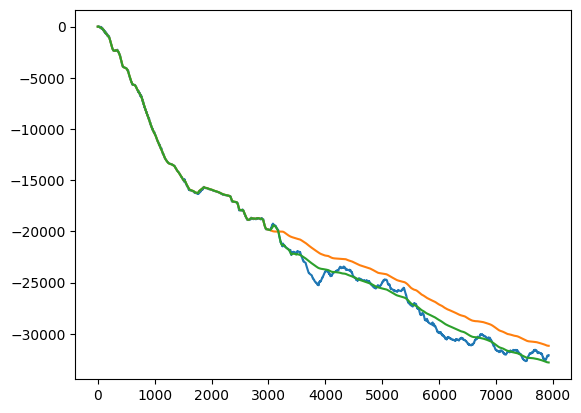

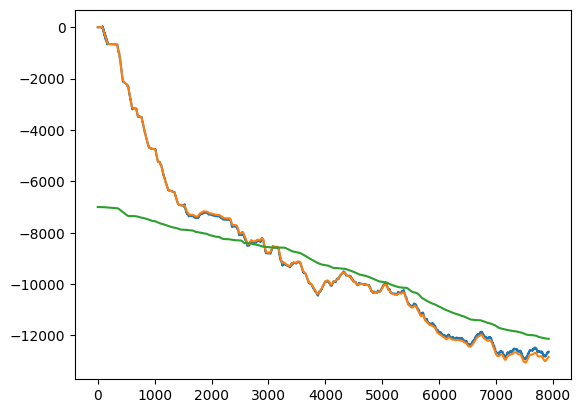

In [343]:
c, d, n = find_charge_discharge(df_power['Skepp 1 - Effekt [MW]'])
for i in range(len(c)):
    diff = np.sum(calc_charge[c[i][0]:c[i][1]] - df_power['Skepp 1 - Effekt [MW]'].iloc[c[i][0]:c[i][1]].values)/(c[i][1]-c[i][0])
    print(f'Charge loss: {diff}')
    if diff > 0:
        print(f':                            {c[i]}')


def GRADIENT_FIRST_COMBINED(energy, time_vec, charge_meas, discharge_meas, df_power, start_time, adj=[1,1]):
    """Calculate through gradient first method. """
    
    # Devide the data into two parts
    beg = slice(0, start_time)
    end = slice(start_time, len(energy))

    cum_energy_loss_beg, gradient_beg = GRADIENT_FIRST_METHOD_new(energy[beg], time_vec[beg], charge_meas[beg], discharge_meas[beg], df_power.iloc[beg], adj=[1,1])
    cum_energy_loss_end , gradient_end = GRADIENT_FIRST_STEADY_LOSSES_ALL(energy[end], time_vec[end], charge_meas[end], discharge_meas[end], df_power.iloc[end], adj=[1,1])

    cum_energy_loss = np.concatenate((cum_energy_loss_beg, cum_energy_loss_end + cum_energy_loss_beg[-1]))
    gradient_first = np.concatenate((gradient_beg, gradient_end))

    return cum_energy_loss, gradient_first



cum_loss_comb, gradient_first_comb = GRADIENT_FIRST_COMBINED(energy_skepp1, temp_time_hours, charge_measured1, discharge_measured1, df_power['Skepp 1 - Effekt [MW]'],3000, adj=[1,1])


cum_loss_comb1, gradient_first_comb1 = GRADIENT_FIRST_COMBINED(energy_skepp1, temp_time_hours, charge_storage1, discharge_storage1, df_power['Skepp 1 - Effekt [MW]'],3000, adj=[1,1])
cum_loss_comb2, gradient_first_comb2 = GRADIENT_FIRST_COMBINED(energy_skepp2, temp_time_hours, charge_storage2, discharge_storage2, df_power['Skepp 2 - Effekt [MW]'],3000, adj=[1,1])
cum_loss_comb3, gradient_first_comb3 = GRADIENT_FIRST_COMBINED(energy_skepp3, temp_time_hours, charge_storage3, discharge_storage3, df_power['Skepp 3 - Effekt [MW]'],3000, adj=[1,1])

plt.plot(temp_time, cum_loss_comb, label='comb')
plt.plot(temp_time, cum_loss_GRADIENT_FIRST_SL1, label='first SL')
plt.legend()
plt.show()


cum_energy_loss_grad_sec1_new, power_loss_vec_calc1_new, gradient_second1_new, power_loss_vec_calc_smoothest1 = GRADIENT_SECOND_METHOD(energy_skepp1, charge_storage1.cumsum(), discharge_storage1.cumsum(), discharge_storage1, temp_time_hours, adj=[1,1])
cum_energy_loss_grad_sec2_new, power_loss_vec_calc2_new, gradient_second2_new, power_loss_vec_calc_smoothest2 = GRADIENT_SECOND_METHOD(energy_skepp2, charge_storage2.cumsum(), discharge_storage2.cumsum(), discharge_storage2, temp_time_hours, adj=[1,1])
cum_energy_loss_grad_sec3_new, power_loss_vec_calc3_new, gradient_second3_new, power_loss_vec_calc_smoothest3 = GRADIENT_SECOND_METHOD(energy_skepp3, charge_storage3.cumsum(), discharge_storage3.cumsum(), discharge_storage3, temp_time_hours, adj=[1,1])

cum_loss_comb11, gradient_first_comb1 = GRADIENT_FIRST_COMBINED(energy_skepp1, temp_time_hours, charge_storage1, discharge_storage1, df_power['Skepp 1 - Effekt [MW]'],3500, adj=[1,1])
cum_loss_comb22, gradient_first_comb2 = GRADIENT_FIRST_COMBINED(energy_skepp2, temp_time_hours, charge_storage2, discharge_storage2, df_power['Skepp 2 - Effekt [MW]'],3500, adj=[1,1])
cum_loss_comb33, gradient_first_comb3 = GRADIENT_FIRST_COMBINED(energy_skepp3, temp_time_hours, charge_storage3, discharge_storage3, df_power['Skepp 3 - Effekt [MW]'],3500, adj=[1,1])

plt.plot( cum_energy_loss_grad_sec1_new + cum_energy_loss_grad_sec2_new + cum_energy_loss_grad_sec3_new, label='Gradient Second 1 new')
plt.plot( cum_loss_comb1 + cum_loss_comb2 + cum_loss_comb3, label='comb')
plt.plot( cum_loss_comb11 + cum_loss_comb22 + cum_loss_comb33, label='comb 2000')
plt.show()

cum_energy_loss_beg, gradient_beg = GRADIENT_FIRST_METHOD_new(energy_skepp1, temp_time_hours, charge_storage1, discharge_storage1, df_power['Skepp 1 - Effekt [MW]'], adj=[1,1])

cum_energy_loss_end , gradient_end = GRADIENT_FIRST_STEADY_LOSSES_ALL(energy_skepp1, temp_time_hours, charge_storage1, discharge_storage1, df_power['Skepp 1 - Effekt [MW]'], adj=[1,1])

plt.plot(cum_energy_loss_grad_sec1_new)
plt.plot(cum_energy_loss_beg)
plt.plot(cum_energy_loss_end-7000)
plt.show()




Det som spanats in ovan...

- testa att hitta en annan effekt från datan, kombinerad lager och fjärr sida. 
    - ger mer effekt under laddning och mindre under urladdning
    - urladdnings förluster får rätt riktning
    - förlusterna blir välidgt stora då men den laddningen och med rätt tecken
    - ingen skillnad mellan grad_first och SL

- förlusterna är extremt känsliga för att om man ändrar 10% på uppmätta effekten, så kan skillnaden mellan uppmätt och uträknad bli välidgt stor då de ligger väldigt nära varandra.

- om man kör med rätt (korrigkerad) tecken, och justerar [1,0.9] så blir det väldigt likt grad_first med SL

- korrigerad så SL påverkas inte av förändring i urladdning

- grad_first_SL är rimligast då den inte tar till hänsyn konstigheterna under urladdning (eventuellt så är det lite merföuster pga ledning och värmeväxlar förluster)

Lastly: should it be this filtered?? above is charactistictime + uniform or only characteristic time. 

Pearson correlation:  -0.25
Spearman correlatio:  -0.23
Loss difference:      105.7 MW
Pearson correlation:  -0.48
Spearman correlatio:  -0.51
Loss difference:      -76.41 MW


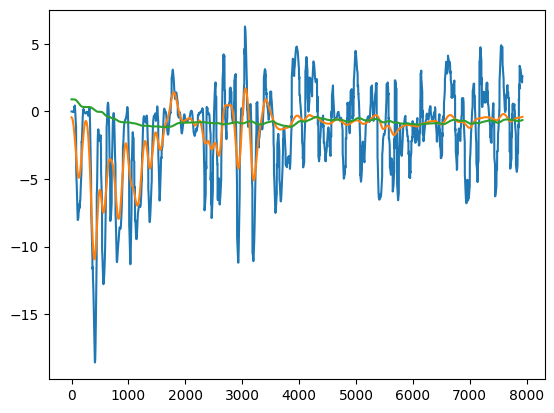

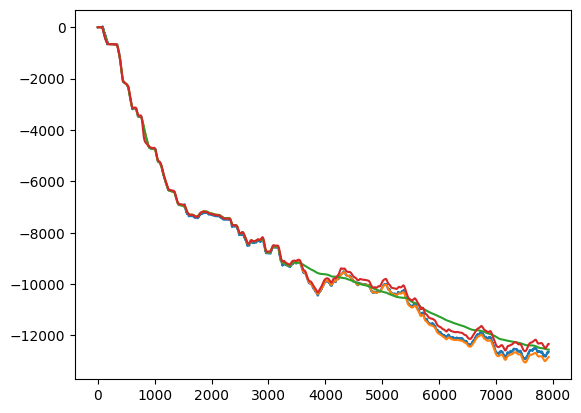

In [ ]:
def ENERGY_DIFF_METHOD_new(df_power, energy, steady_losses, cum_charge_meas, cum_discharge_meas, adj=[1,1]):
    """Calculate power based on energy difference. """

    # Use function to calculate the effective power (charge and discharge) 
    effective_calc_power_mean = calulate_charge_based_on_energy(df_power, energy)

    # Find the effective charge & discharge
    charge_calc_eff = np.where(effective_calc_power_mean > 0, effective_calc_power_mean, 0)
    discharge_calc_eff = np.where(effective_calc_power_mean < 0, effective_calc_power_mean, 0)

    # Calculate the cumulative charge & discharge & steady losses
    cum_charge_calc_eff = charge_calc_eff.cumsum()
    cum_discharge_calc_eff = discharge_calc_eff.cumsum()
    cum_steady_losses = steady_losses.cumsum()

    # Calculate the cumulative energy loss
    cum_loss_during_charging = (-cum_charge_meas*adj[0] + cum_charge_calc_eff)
    cum_loss_during_discharging = (-cum_discharge_meas*adj[1] + cum_discharge_calc_eff)
    
    # Total cumulative loss
    cum_loss_ENERGY_DIFF = (cum_loss_during_charging + cum_loss_during_discharging + cum_steady_losses)/1000

    #cum_loss_ENERGY_DIFF = smooth_cumulative_loss(cum_loss_ENERGY_DIFF, search_back=150)

    cum_loss_ENERGY_DIFF = savgol_filter(cum_loss_ENERGY_DIFF , window_length=72, polyorder=3)
    
    return cum_loss_ENERGY_DIFF # ALSO CALCULATE THE POWER LOSS VECTOR, or effective_calc_power_mean

cum_energy_loss_beg, gradient_beg = GRADIENT_FIRST_METHOD_new(energy_skepp1, temp_time_hours, charge_storage1, discharge_storage1, df_power['Skepp 1 - Effekt [MW]'], adj=[1,1])
cum_loss_comb11, gradient_first_comb1 = GRADIENT_FIRST_COMBINED(energy_skepp1, temp_time_hours, charge_storage1, discharge_storage1, df_power['Skepp 1 - Effekt [MW]'],3500, adj=[1,1])

fitted_loss_new, gradient_first_new_smoothest, pearson_corr, spearman_corr, loss_diff = power_loss_fit_smooth(energy_skepp1, gradient_beg ,power_loss_predicted_normalized)

fitted_loss_new, gradient_first_new_smoothest, pearson_corr, spearman_corr, loss_diff = power_loss_fit_smooth(energy_skepp1, gradient_first_comb1 ,power_loss_predicted_normalized)


cum_loss_ENERGY_DIFF1 = ENERGY_DIFF_METHOD_new(df_power['Skepp 1 - Effekt [MW]'], energy_skepp1, steady_losses1, charge_storage1.cumsum(), discharge_storage1.cumsum())*1000


plt.plot(gradient_beg)
plt.plot(gradient_first_new_smoothest)
plt.plot(fitted_loss_new)
plt.show()

plt.plot(cum_energy_loss_grad_sec1_new)
plt.plot(cum_energy_loss_beg)
plt.plot(cum_loss_comb11)
plt.plot(cum_loss_ENERGY_DIFF1)
plt.show()

Indices where the bedrock migh give back energy:
[3404 3405 4314 5030 5039 5040 5378 5388 5658 5791 6424]


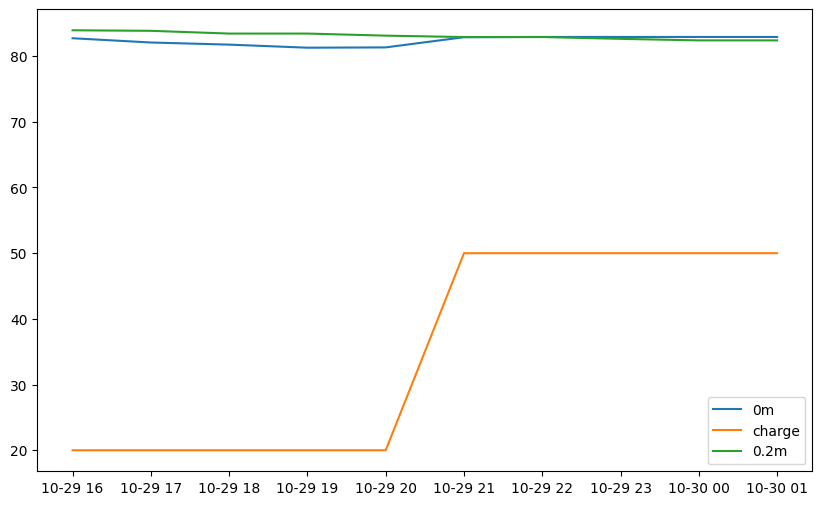

In [318]:
# Adjust charge and discharge to 1 and -1, respectively
binary_power = df_power['Skepp 2 - Effekt [MW]'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# Find indices where binary power is zero and the gradient of skepp2_temp_level18 is positive
indices = np.where((np.gradient(skepp2_temp_level18) > 0.05) & (np.gradient(df_berg_temp['0.2m'].values)< -0.05))[0]
print('Indices where the bedrock migh give back energy:')
print(indices)

# no detection of the bedrock giving back energy
when = slice(3400, 3410)
plt.figure(figsize=(10, 6))
plt.plot(temp_time[when], skepp2_temp_level18[when], label='0m') 
plt.plot(temp_time[when], binary_power[when]*30+50, label='charge') 
plt.plot(df_berg_temp['time'].iloc[when], df_berg_temp['0.2m'].iloc[when], label='0.2m')
plt.legend()

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.77621298e-02 -5.31044559e-02
 -3.03055766e-04 -2.50336504e-02 -1.71661377e-02 -7.15944385e-03
  2.47637367e-02  3.53616982e-02 -3.79975472e-02  5.30389405e-03
  3.38331757e-02  0.00000000e+00 -2.61883259e-02 -3.51795664e-02
 -6.93245794e-03 -1.72320099e-02 -3.95839881e-03  3.87029371e-02
 -2.01616476e-03 -5.74074020e-02 -9.93833352e-03  2.88146887e-02
 -3.83475304e-03 -2.71497803e-02 -3.29622545e-02 -7.45567074e-02
 -1.22783535e-01 -1.29043797e-01 -1.41327430e-01 -1.21769530e-01
 -1.25533879e-01 -1.64858966e-01 -1.31106668e-01 -1.27466079e-01
 -1.71149761e-01 -1.71395652e-01 -1.52687961e-01 -1.55538505e-01
 -1.77555430e-01 -1.89016457e-01 -1.83995263e-01 -1.93353047e-01
 -2.33044461e-01 -2.17700589e-01 -2.25440764e-01 -2.59163032e-01
 -2.66990303e-01 -3.45846262e-01 -3.71872976e-01 -3.74721049e-01
 -4.00404518e-01 -4.09549413e-01 -4.75579865e-01 -5.07667758e-01
 -6.20949611e-01 -6.57394

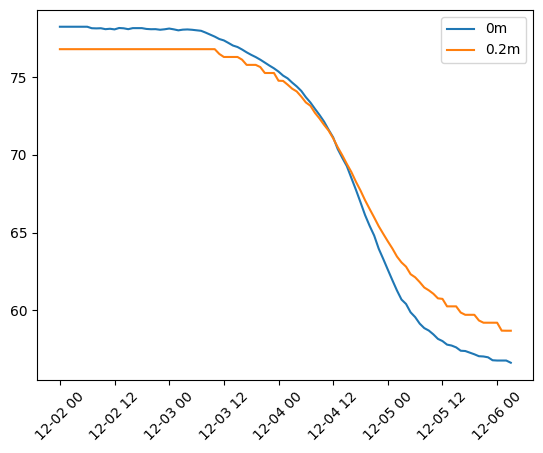

In [321]:
when = slice(4200, 4300)  # Adjust the slice as needed
plt.plot(temp_time[when], skepp2_temp_level18[when], label='0m') 
plt.plot(df_berg_temp['time'].iloc[when], df_berg_temp['0.2m'].iloc[when], label='0.2m')
plt.xticks(rotation=45)
plt.legend()

grad_water = np.gradient(skepp2_temp_level18[when], temp_time_hours[when])
grad_bedrock = np.gradient(df_berg_temp['0.2m'].iloc[when], temp_time_hours[when])
print(grad_water)
print(grad_bedrock)
